<h3> Impact of Bus Transport Accessibility on Rental Prices in Greater Manchester <h3>

<h3>INTRODUCTON</h3>
This study investigates how the accessibility of bus transport impacts rental prices in Greater Manchester. The focus is on understanding whether high accessibility, characterized by the presence of unique bus lines and routes within 200m and 400m proximity of rental listings, positively affects rental prices. The second objective is to investigate whether the effect of bus accessibility on rental prices is stronger in suburban areas compared to central areas of Greater Manchester.


In [22]:
#Importing necessary libraries 
import pandas as pd
import numpy as np
import geopandas as gpd
import matplotlib.pyplot as plt
from shapely.geometry import Point
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.inspection import partial_dependence, permutation_importance
from sklearn.ensemble import RandomForestRegressor
from scipy.stats import shapiro
from sklearn.linear_model import LinearRegression
from skopt import gp_minimize
from skopt.space import Real, Integer
from skopt.utils import use_named_args
import statsmodels.api as sm
from statsmodels.stats.diagnostic import het_breuschpagan
from statsmodels.stats.outliers_influence import variance_inflation_factor
from statsmodels.regression.quantile_regression import QuantReg
from esda.moran import Moran_Local
import warnings
from libpysal.weights import DistanceBand, Queen
from pysal.explore import esda
import mapclassify
import xgboost as xgb
import googlemaps
import zipfile
import os
import time
import math
from esda.getisord import G_Local
from mgwr.gwr import GWR
from mgwr.sel_bw import Sel_BW
from mpl_toolkits.axes_grid1 import make_axes_locatable
import matplotlib.colors as mcolors


<h3>DATASET</h3>


The primary dataset comprises 5,703 unique rental listings collected from [propertydata.co.uk](https://propertydata.co.uk/) across various districts of Greater Manchester, including Bolton, Stockport, Trafford, Wigan, Rochdale, Bury, Salford, and Tameside. This dataset provides detailed information on rental prices and property attributes, such as the number of bedrooms and property type. To assess the impact of public transportation accessibility on rental prices, several key variables were derived using bus timetable data and spatial analysis with GeoPandas. Buffers of 200 meters and 400 meters were created around each property to quantify proximity to bus stops. Additionally, the deprivation index dataset from the UK government was incorporated and matched with Middle Layer Super Output Areas (MSOAs) by aggregating data from Lower Layer Super Output Areas (LSOAs). Thus, the Index of Multiple Deprivation was associated with each rental listing based on the MSOA it belonged to.


In [5]:
# Load the rental listings data
rental_csv_path = '/content/sample_data/rental analysis/new_rentals.xls'
rental_df = pd.read_csv(rental_csv_path)

# Load the bus stops data from a zipped file
zip_file_path = '/content/sample_data/rental analysis/my_dataframe.zip'
with zipfile.ZipFile(zip_file_path, 'r') as zip_ref:
    # Extract and load the first file in the zip archive
    csv_filename = zip_ref.namelist()[0]
    zip_ref.extract(csv_filename, path='/content/sample_data/rental analysis')
bus_stops_path = f'/content/sample_data/rental analysis/{csv_filename}'
bus_stops_df = pd.read_csv(bus_stops_path)

# Load the matched bus stops with MSOA and LSOA data
lsoa_msoa_path = '/content/sample_data/rental analysis/atcoXmsoaXlsoa_full.csv'
lsoa_msoa_df = pd.read_csv(lsoa_msoa_path)

# Load the LSOA to ATCO data
lsoa_atco_path = '/content/sample_data/rental analysis/atco&lsoa.xls'
lsoa_atco_df = pd.read_csv(lsoa_atco_path)

# Load the LSOA to MSOA data
lsoa_msoa_additional_path = '/content/sample_data/rental analysis/lsoa_msoa.xls'
lsoa_msoa_additional_df = pd.read_csv(lsoa_msoa_additional_path)

# Load the deprivation index by LSOA dataset
workbook_path = '/content/sample_data/rental analysis/deprivation scores 2019.xlsx'
sheet_name = 'IoD2019 Scores'  # Specific sheet name in the workbook
deprivation_df = pd.read_excel(workbook_path, sheet_name=sheet_name)


In [ ]:
# Load the UK boundary data for districts
file = 'UK_boundary_data/GB/district_borough_unitary_region.shp'
df_uk = gpd.read_file(file)

# Define the districts that make up Greater Manchester
greater_manchester_districts = [
    'Manchester District (B)',
    'Bury District (B)',
    'Oldham District (B)',
    'Rochdale District (B)',
    'Salford District (B)',
    'Trafford District (B)',
    'Stockport District (B)',
    'Tameside District (B)',
    'Bolton District (B)',
    'Wigan District (B)',
]

# Filter the DataFrame to include only the districts within Greater Manchester
gmcr_boroughs = df_uk[df_uk['NAME'].isin(greater_manchester_districts)]

# Ensure the Coordinate Reference System (CRS) is set to EPSG:4326
gmcr_boroughs = gmcr_boroughs.to_crs(epsg=4326)

# Load the MSOA shapefile for spatial analysis
msoa_shapefile_path = "atco to lsoa/MSOA_2001_EW_BFE_V2.shp"
msoa_gpd = gpd.read_file(msoa_shapefile_path)

# Ensure the MSOA GeoDataFrame CRS matches EPSG:4326
msoa_gpd = msoa_gpd.to_crs(epsg=4326)

# Identify the MSOAs that intersect with the Greater Manchester districts
gmcr_msoas = gpd.overlay(msoa_gpd, gmcr_boroughs, how='intersection')

# Plot the boundaries of Greater Manchester boroughs and the MSOAs
fig, ax = plt.subplots(figsize=(10, 10))
gmcr_boroughs.boundary.plot(ax=ax, linewidth=1, edgecolor='black')
gmcr_msoas.boundary.plot(ax=ax, linewidth=1, edgecolor='blue')

# Optionally, fill the MSOAs with a semi-transparent color
gmcr_msoas.plot(ax=ax, alpha=0.5, edgecolor='k')

ax.set_title('Greater Manchester MSOAs')
plt.show()



<h3>DATA PREPROCESSING<h3>

In [26]:
## Section 1: Filtering the bus data to include weekdays for this study
bus_stops_df.drop(columns=['JP'], inplace=True)
# Filter rows where 'OD' column has the specified value
bus_stops_df = bus_stops_df[bus_stops_df['OD'] == 'Monday,Tuesday,Wednesday,Thursday,Friday,']

In [29]:
## Section 2: Rental data - Cleaning and adding unique rental IDs
# Find exact duplicate rows
exact_duplicates = rental_csv[rental_csv.duplicated(keep=False)]
# Display the exact duplicate rows
print("Exact duplicate rows:")
display(exact_duplicates)
# Remove the exact duplicate rows
rental_csv_cleaned = rental_csv.drop_duplicates()
# Add a unique rental ID column to the cleaned DataFrame
rental_csv_cleaned['unique_rental_id'] = range(1, len(rental_csv_cleaned) + 1)
rental_listings = rental_csv_cleaned.drop(columns=['Unnamed: 0'])
# Display the first few rows of the updated DataFrame to verify
print(rental_listings.head())

Address Postcode  \
0                           Plodder Lane, Bolton  BL4 0BT   
1  Heaton Grange, Bolton, Greater Manchester BL1  BL1 5BP   
2           20 Braybrook Drive, Lostock, BL1 5XA  BL1 5XJ   
3                   Chorley New Road, Bolton BL6  BL6 4DL   
4                     Halliwell Road, Bolton BL1  BL1 8BZ   

                  Type  Bedrooms  Asking rent (pm)  Days        Lat       Lng  \
0       Terraced house       6.0               412    38  53.548880 -2.416711   
1       Detached house       5.0              1798    19  53.579554 -2.466196   
2       Detached house       5.0              2002    73  53.577734 -2.490968   
3  Semi-detached house       5.0              3748    90  53.579512 -2.501245   
4       Terraced house       4.0              1274    37  53.596035 -2.450734   

   unique_rental_id  
0                 1  
1                 2  
2                 3  
3                 4  
4                 5

In [33]:
## Section 3: Adding LSOA and MSOA columns to the bus_stops_df
# Step 1: Merge bus_stops_df with lsoa_atco on ATCOCODE to add LSOA
bus_stops_with_lsoa = bus_stops_df.merge(lsoa_atco[['ATCOCODE', 'LSOA']], on='ATCOCODE', how='left')
# Step 2: Merge the resulting dataframe with lsoa_msoa on LSOA to add MSOA
bus_stops_df = bus_stops_with_lsoa.merge(lsoa_msoa[['LSOA', 'MSOA']], on='LSOA', how='left')
# Display the resulting dataframe
print(bus_stops_df.head())

         Seq no Line   RouteID     VJ    JC  \
0             1  286   rt_0000   vj_1  1001   
1             1  286   rt_0000   vj_1  1001   
2             1  286   rt_0000   vj_1  1001   
3             1  286   rt_0000   vj_1  1001   
4             1  286   rt_0000   vj_1  1001   
...         ...  ...       ...    ...   ...   
4135266      70  635  rt_00011  vj_46  1087   
4135267      70  635  rt_00011  vj_46  1087   
4135268      70  635  rt_00011  vj_46  1087   
4135269      70  635  rt_00011  vj_46  1087   
4135270      70  635  rt_00011  vj_46  1087   

                                                OD     ATCOCODE  Time  \
0        Monday,Tuesday,Wednesday,Thursday,Friday,  1800AMIC001   367   
1        Monday,Tuesday,Wednesday,Thursday,Friday,  1800AMIC001   367   
2        Monday,Tuesday,Wednesday,Thursday,Friday,  1800AMIC001   367   
3        Monday,Tuesday,Wednesday,Thursday,Friday,  1800AMIC001   367   
4        Monday,Tuesday,Wednesday,Thursday,Friday,  1800AMIC001   367 

In [36]:
## Section 4: Adding the deprivation index for the MSOA for each row
# Rename the LSOA column in sheet_df to ensure proper merging
sheet_df.rename(columns={'LSOA code (2011)': 'LSOA'}, inplace=True)
# Select columns from sheet_df to add
columns_to_add = ['LSOA', 'Index of Multiple Deprivation (IMD) Score']
# Merge with sheet_df
bus_stops_df = bus_stops_df.merge(sheet_df[columns_to_add], on='LSOA', how='left')
# Display the resulting dataframe
print(bus_stops_df.head())


   Seq no Line  RouteID    VJ    JC  \
0       1  286  rt_0000  vj_1  1001   
1       1  286  rt_0000  vj_1  1001   
2       1  286  rt_0000  vj_1  1001   
3       1  286  rt_0000  vj_1  1001   
4       1  286  rt_0000  vj_1  1001   

                                          OD     ATCOCODE  Time NaptanCode  \
0  Monday,Tuesday,Wednesday,Thursday,Friday,  1800AMIC001   367   MANADADG   
1  Monday,Tuesday,Wednesday,Thursday,Friday,  1800AMIC001   367   MANADADG   
2  Monday,Tuesday,Wednesday,Thursday,Friday,  1800AMIC001   367   MANADADG   
3  Monday,Tuesday,Wednesday,Thursday,Friday,  1800AMIC001   367   MANADADG   
4  Monday,Tuesday,Wednesday,Thursday,Friday,  1800AMIC001   367   MANADADG   

  GridType   Easting  Northing  Longitude   Latitude  Status Direction  \
0     UKOS  376983.0  387906.0   -2.34754  53.387509  active  outbound   
1     UKOS  376983.0  387906.0   -2.34754  53.387509  active  outbound   
2     UKOS  376983.0  387906.0   -2.34754  53.387509  active  outbound   


<h4> SPATIAL MATCHING OF RENTAL LISTINGS WITH BUS STOPS IN 200 METER AND 400 METER BUFFER ZONES <h4>

In [38]:
# Create GeoDataFrame for rentals
geometry_rentals = [Point(xy) for xy in zip(rental_listings['Lng'], rental_listings['Lat'])]
gdf_rentals = gpd.GeoDataFrame(rental_listings, geometry=geometry_rentals)

# Create GeoDataFrame for bus stops
geometry_bus_stops = [Point(xy) for xy in zip(bus_stops_df['Longitude'], bus_stops_df['Latitude'])]
gdf_bus_stops = gpd.GeoDataFrame(bus_stops_df, geometry=geometry_bus_stops)

# Set CRS to EPSG:4326 (WGS 84)
gdf_rentals.set_crs(epsg=4326, inplace=True)
gdf_bus_stops.set_crs(epsg=4326, inplace=True)

# Transform CRS to a projected system (e.g., UTM zone 30N)
gdf_rentals = gdf_rentals.to_crs(epsg=32630)
gdf_bus_stops = gdf_bus_stops.to_crs(epsg=32630)



Seq no Line   RouteID     VJ    JC  \
0             1  286   rt_0000   vj_1  1001   
1             1  286   rt_0000   vj_1  1001   
2             1  286   rt_0000   vj_1  1001   
3             1  286   rt_0000   vj_1  1001   
4             1  286   rt_0000   vj_1  1001   
...         ...  ...       ...    ...   ...   
4135266      70  635  rt_00011  vj_46  1087   
4135267      70  635  rt_00011  vj_46  1087   
4135268      70  635  rt_00011  vj_46  1087   
4135269      70  635  rt_00011  vj_46  1087   
4135270      70  635  rt_00011  vj_46  1087   

                                                OD     ATCOCODE  Time  \
0        Monday,Tuesday,Wednesday,Thursday,Friday,  1800AMIC001   367   
1        Monday,Tuesday,Wednesday,Thursday,Friday,  1800AMIC001   367   
2        Monday,Tuesday,Wednesday,Thursday,Friday,  1800AMIC001   367   
3        Monday,Tuesday,Wednesday,Thursday,Friday,  1800AMIC001   367   
4        Monday,Tuesday,Wednesday,Thursday,Friday,  1800AMIC001   367   
...                                            ...          ...   ...   
4135266  Monday,Tuesday,Wednesday,Thursday,Friday,  1800WNBSAR1  1433   
4135267  Monday,Tuesday,Wednesday,Thursday,Friday,  1800WNBSAR1  1433   
4135268  Monday,Tuesday,Wednesday,Thursday,Friday,  1800WNBSAR1  1433   
4135269  Monday,Tuesday,Wednesday,Thursday,Friday,  1800WNBSAR1  1433   
4135270  Monday,Tuesday,Wednesday,Thursday,Friday,  1800WNBSAR1  1433   

        NaptanCode GridType   Easting  Northing  Longitude   Latitude  Status  \
0         MANADADG     UKOS  376983.0  387906.0  -2.347540  53.387509  active   
1         MANADADG     UKOS  376983.0  387906.0  -2.347540  53.387509  active   
2         MANADADG     UKOS  376983.0  387906.0  -2.347540  53.387509  active   
3         MANADADG     UKOS  376983.0  387906.0  -2.347540  53.387509  active   
4         MANADADG     UKOS  376983.0  387906.0  -2.347540  53.387509  active   
...            ...      ...       ...       ...        ...        ...     ...   
4135266        NaN     UKOS  358061.0  405858.0  -2.634421  53.547685  active   
4135267        NaN     UKOS  358061.0  405858.0  -2.634421  53.547685  active   
4135268        NaN     UKOS  358061.0  405858.0  -2.634421  53.547685  active   
4135269        NaN     UKOS  358061.0  405858.0  -2.634421  53.547685  active   
4135270        NaN     UKOS  358061.0  405858.0  -2.634421  53.547685  active   

        Direction       LSOA       MSOA  \
0        outbound  E01006075  E02001283   
1        outbound  E01006075  E02001283   
2        outbound  E01006075  E02001283   
3        outbound  E01006075  E02001283   
4        outbound  E01006075  E02001283   
...           ...        ...        ...   
4135266  outbound  E01006369  E02001294   
4135267  outbound  E01006369  E02001294   
4135268  outbound  E01006369  E02001294   
4135269  outbound  E01006369  E02001294   
4135270  outbound  E01006369  E02001294   

         Index of Multiple Deprivation (IMD) Score                   geometry  
0                                            6.405  POINT (-2.34754 53.38751)  
1                                            6.405  POINT (-2.34754 53.38751)  
2                                            6.405  POINT (-2.34754 53.38751)  
3                                            6.405  POINT (-2.34754 53.38751)  
4                                            6.405  POINT (-2.34754 53.38751)  
...                                            ...                        ...  
4135266                                     51.259  POINT (-2.63442 53.54769)  
4135267                                     51.259  POINT (-2.63442 53.54769)  
4135268                                     51.259  POINT (-2.63442 53.54769)  
4135269                                     51.259  POINT (-2.63442 53.54769)  
4135270                                     51.259  POINT (-2.63442 53.54769)  

[4135271 rows x 20 columns]

In [40]:
# Function to process a chunk of rental listings for memory efficiency 
def process_chunk(chunk, gdf_bus_stops, buffer_distance):
    # Buffer the rental points by 200 meters 
    chunk['geometry'] = chunk.geometry.buffer(buffer_distance)
    # Perform spatial join to find bus stops within the buffer of rental listings
    joined_chunk = gpd.sjoin(chunk, gdf_bus_stops, how="inner", predicate='intersects')
    return joined_chunk


In [41]:
# Split the rental listings GeoDataFrame into chunks
chunk_size = 50
chunks = np.array_split(gdf_rentals, len(gdf_rentals) // chunk_size + 1)

# Process each chunk and collect results
buffer_distance = 200  # 200 meters
joined_chunks_200 = []

for i, chunk in enumerate(chunks):
    print(f"Processing chunk {i+1}/{len(chunks)}")
    joined_chunk = process_chunk(chunk, gdf_bus_stops, buffer_distance)
    joined_chunks_200.append(joined_chunk)


Processing chunk 1/80
Processing chunk 2/80
Processing chunk 3/80
Processing chunk 4/80
Processing chunk 5/80
Processing chunk 6/80
Processing chunk 7/80
Processing chunk 8/80
Processing chunk 9/80
Processing chunk 10/80
Processing chunk 11/80
Processing chunk 12/80
Processing chunk 13/80
Processing chunk 14/80
Processing chunk 15/80
Processing chunk 16/80
Processing chunk 17/80
Processing chunk 18/80
Processing chunk 19/80
Processing chunk 20/80
Processing chunk 21/80
Processing chunk 22/80
Processing chunk 23/80
Processing chunk 24/80
Processing chunk 25/80
Processing chunk 26/80
Processing chunk 27/80
Processing chunk 28/80
Processing chunk 29/80
Processing chunk 30/80
Processing chunk 31/80
Processing chunk 32/80
Processing chunk 33/80
Processing chunk 34/80
Processing chunk 35/80
Processing chunk 36/80
Processing chunk 37/80
Processing chunk 38/80
Processing chunk 39/80
Processing chunk 40/80
Processing chunk 41/80
Processing chunk 42/80
Processing chunk 43/80
Processing chunk 44/

In [71]:
#Similarly, performing spatial match of rental listings with bus stops within 400m radius 
chunk_size = 20
chunks = np.array_split(gdf_rentals, len(gdf_rentals) // chunk_size + 1)

# Process each chunk and collect results
buffer_distance = 400  # 200 meters
joined_chunks_400 = []

for i, chunk in enumerate(chunks):
    print(f"Processing chunk {i+1}/{len(chunks)}")
    joined_chunk = process_chunk(chunk, gdf_bus_stops, buffer_distance)
    joined_chunks_400.append(joined_chunk)


Processing chunk 1/199
Processing chunk 2/199
Processing chunk 3/199
Processing chunk 4/199
Processing chunk 5/199
Processing chunk 6/199
Processing chunk 7/199
Processing chunk 8/199
Processing chunk 9/199
Processing chunk 10/199
Processing chunk 11/199
Processing chunk 12/199
Processing chunk 13/199
Processing chunk 14/199
Processing chunk 15/199
Processing chunk 16/199
Processing chunk 17/199
Processing chunk 18/199
Processing chunk 19/199
Processing chunk 20/199
Processing chunk 21/199
Processing chunk 22/199
Processing chunk 23/199
Processing chunk 24/199
Processing chunk 25/199
Processing chunk 26/199
Processing chunk 27/199
Processing chunk 28/199
Processing chunk 29/199
Processing chunk 30/199
Processing chunk 31/199
Processing chunk 32/199
Processing chunk 33/199
Processing chunk 34/199
Processing chunk 35/199
Processing chunk 36/199
Processing chunk 37/199
Processing chunk 38/199
Processing chunk 39/199
Processing chunk 40/199
Processing chunk 41/199
Processing chunk 42/199
P

In [ ]:
# Concatenate all the joined chunks into a single GeoDataFrame
joined_gdf_200 = gpd.GeoDataFrame(pd.concat(joined_chunks_200, ignore_index=True))
joined_gdf_400 = gpd.GeoDataFrame(pd.concat(joined_chunks_400, ignore_index=True))

In [ ]:
# Assign a unique ID to each rental listing
rental_listings['unique_rental_id'] = range(1, len(rental_listings) + 1)

# Define buffer distances and corresponding columns
buffers = [200, 300, 400]
buffer_suffixes = ['200m', '400m']

# Function to count unique ATCOCODEs, Lines, and RouteIDs within a specified buffer
def count_unique_features(joined_gdf, buffer_suffix):
    # Step 1: Count unique ATCOCODEs
    bus_stop_counts = joined_gdf.groupby('unique_rental_id')['ATCOCODE'].nunique().reset_index()
    bus_stop_counts.rename(columns={'ATCOCODE': f'no_of_bus_stops_in_{buffer_suffix}'}, inplace=True)
    
    # Step 2: Count unique Lines
    line_counts = joined_gdf.groupby('unique_rental_id')['Line'].nunique().reset_index()
    line_counts.rename(columns={'Line': f'no_of_unique_lines_{buffer_suffix}'}, inplace=True)
    
    # Step 3: Count unique RouteIDs
    routeid_counts = joined_gdf.groupby('unique_rental_id')['RouteID'].nunique().reset_index()
    routeid_counts.rename(columns={'RouteID': f'no_of_unique_routeids_{buffer_suffix}'}, inplace=True)
    
    # Step 4: Merge the counts back to the rental listings DataFrame
    rental_listings_with_bus_stops = pd.merge(rental_listings, bus_stop_counts, on='unique_rental_id', how='left')
    rental_listings_with_bus_stops = pd.merge(rental_listings_with_bus_stops, line_counts, on='unique_rental_id', how='left')
    rental_listings_with_bus_stops = pd.merge(rental_listings_with_bus_stops, routeid_counts, on='unique_rental_id', how='left')
    
    # Step 5: Fill NaN values with 0
    rental_listings_with_bus_stops[f'no_of_bus_stops_in_{buffer_suffix}'].fillna(0, inplace=True)
    rental_listings_with_bus_stops[f'no_of_unique_lines_{buffer_suffix}'].fillna(0, inplace=True)
    rental_listings_with_bus_stops[f'no_of_unique_routeids_{buffer_suffix}'].fillna(0, inplace=True)
    
    return rental_listings_with_bus_stops

# Process each buffer distance
for buffer, buffer_suffix in zip(buffers, buffer_suffixes):
    if buffer == 200:
        rental_listings_with_bus_stops = count_unique_features(joined_gdf_200, buffer_suffix)
    elif buffer == 400:
        rental_listings_with_bus_stops = count_unique_features(joined_gdf_400, buffer_suffix)

In [76]:
# Step 1: Select the desired columns from joined_gdf_200 and remove duplicates
unique_rentals_lsoa_msoa = joined_gdf_200[['unique_rental_id', 'LSOA', 'MSOA', 'Index of Multiple Deprivation (IMD) Score', 'geometry']].drop_duplicates()
# Step 2: Merge the selected columns with the rental_listings_with_bus_stops DataFrame
rental_listings_with_lsoa_msoa = pd.merge(rental_listings_with_bus_stops, unique_rentals_lsoa_msoa, on='unique_rental_id', how='left')
# Display the first few rows of the resulting DataFrame
print(rental_listings_with_lsoa_msoa.head())


                                         Address Postcode  \
0                           Plodder Lane, Bolton  BL4 0BT   
1  Heaton Grange, Bolton, Greater Manchester BL1  BL1 5BP   
2  Heaton Grange, Bolton, Greater Manchester BL1  BL1 5BP   
3           20 Braybrook Drive, Lostock, BL1 5XA  BL1 5XJ   
4                   Chorley New Road, Bolton BL6  BL6 4DL   

                  Type  Bedrooms  Asking rent (pm)  Days        Lat       Lng  \
0       Terraced house       6.0               412    38  53.548880 -2.416711   
1       Detached house       5.0              1798    19  53.579554 -2.466196   
2       Detached house       5.0              1798    19  53.579554 -2.466196   
3       Detached house       5.0              2002    73  53.577734 -2.490968   
4  Semi-detached house       5.0              3748    90  53.579512 -2.501245   

   unique_rental_id  no_of_bus_stops_in_200m  ...  no_of_bus_stops_in_300m  \
0                 1                        3  ...                   

<H3> RENTAL MAP OF GREATER MANCHESTER WITH RESPECT TO BUS LINES<H3>

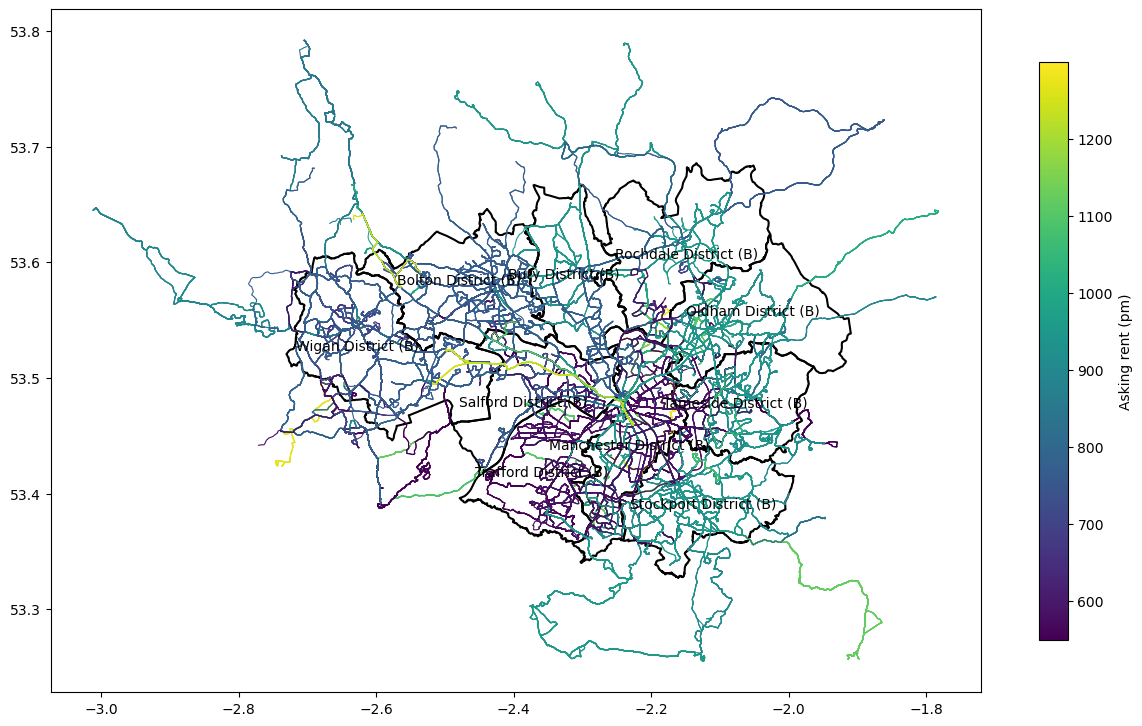

In [17]:
# Make sure both GeoDataFrames are using the same CRS
gdf = gdf.to_crs(gmcr_boroughs.crs)

# Normalize the price data for coloring
norm = mcolors.Normalize(vmin=gdf['Asking rent (pm)'].min(), vmax=gdf['Asking rent (pm)'].max())

# Prepare a color map
colormap = plt.cm.ScalarMappable(norm=norm, cmap='viridis')
colormap.set_array([])  # This is needed to initialize the ScalarMappable

# Plot the borough borders
fig, ax = plt.subplots(figsize=(15, 15))
gmcr_boroughs.boundary.plot(ax=ax, edgecolor='black')

# Plot the priced bus routes with the color mapped to price
gdf.plot(ax=ax, column='Asking rent (pm)', cmap='viridis', linewidth=0.8)

# Add the color bar using the normalized data
cbar = plt.colorbar(colormap, ax=ax, shrink=0.5)
cbar.set_label('Asking rent (pm)')

# Annotate the district names on the plot
for idx, row in gmcr_boroughs.iterrows():
    # Some logic to place the text in the center of the district
    xy = row['geometry'].representative_point().coords[:]
    ax.annotate(text=row['NAME'], xy=xy[0], ha='center', va='center')

# Show the plot
plt.show()



This map of Greater Manchester (GM) illustrates the bus routes with a color-coded representation of asking rent prices per month. The green lines indicate the priciest areas, primarily concentrated along certain routes that likely pass through more affluent neighborhoods. This visualization highlights the disparity in housing costs across GM, with the most expensive areas being well-connected by bus routes. Such a map can provide valuable insights for urban planners, real estate developers, and prospective tenants regarding housing affordability and accessibility.

<h4> PLACES API TO GET DISTANCES FROM NEAREST POINTS OF INTERESTS <H4>

In [ ]:
# Convert miles to meters
def miles_to_meters(miles):
    try:
        return miles * 1609.344
    except:
        return 0
# Initialize the Google Maps client with a valid API key
API_key = open('api_gm.txt', 'r').read().strip()
map_client = googlemaps.Client(key=API_key)

# Define Earth's radius in meters for distance conversion
EARTH_RADIUS = 6371000  # in meters

# Convert degrees to radians for latitude and longitude for computation
def to_radians(degrees):
    return np.radians(degrees)


In [ ]:
def get_nearest_place(lat, lon, search_string, place_type, distance_miles):
    """Generic function to find the nearest place of a given type within a specified distance."""
    distance = miles_to_meters(distance_miles)
    location = (lat, lon)
    nearest_place_info = {'distance': None, 'name': None}
    
    try:
        response = map_client.places_nearby(location=location, keyword=search_string, radius=distance, type=place_type)
        
        if response.get('results'):
            rental_location_radians = np.array([to_radians(lat), to_radians(lon)]).reshape(1, -1)
            place_distances = []
            for place in response['results']:
                place_location_radians = np.array([[to_radians(place['geometry']['location']['lat']), to_radians(place['geometry']['location']['lng'])]])
                distance_matrix = haversine_distances(rental_location_radians, place_location_radians)
                distance_in_meters = distance_matrix * EARTH_RADIUS
                place_distances.append((place['name'], np.min(distance_in_meters)))
            
            nearest_place_name, nearest_place_distance = min(place_distances, key=lambda x: x[1])
            nearest_place_info['name'] = nearest_place_name
            nearest_place_info['distance'] = nearest_place_distance
    except googlemaps.exceptions.ApiError as e:
        print(f"API error: {e}")
    except Exception as e:
        print(f"An error occurred: {e}")
    
    return nearest_place_info

def process_places(unique_rentals, place_type, search_string, distance_miles):
    """Process and find nearest places for all rentals."""
    column_distance = f'nearest_{place_type}_distance'
    column_name = f'nearest_{place_type}_name'
    
    unique_rentals[column_distance] = pd.NA
    unique_rentals[column_name] = None
    
    start_time = time.time()
    checkpoint_frequency = 100  # Save progress every 100 rows
    
    for index, row in unique_rentals.iterrows():
        if pd.isna(row[column_distance]):
            try:
                print(f"Processing row {index + 1}/{len(unique_rentals)} for {place_type}")
                place_info = get_nearest_place(row['Lat'], row['Lng'], search_string, place_type, distance_miles)
                unique_rentals.at[index, column_distance] = place_info['distance']
                unique_rentals.at[index, column_name] = place_info['name']
                print(f"Processed row {index + 1}/{len(unique_rentals)} - Nearest {place_type.capitalize()}: {place_info['name']}, Distance: {place_info['distance']} meters")
                time.sleep(0.1)  # Adjust the sleep time as needed
            except Exception as e:
                print(f"An error occurred at row {index + 1}: {e}")
            
            if (index + 1) % checkpoint_frequency == 0:
                unique_rentals.to_csv(f'progress_{place_type}.csv', index=False)
                print(f"Progress saved at row {index + 1}")
    
    print("Total time taken:", time.time() - start_time)
    return unique_rentals

# Load the rental listings data
unique_rentals_path = 'path_to_your_unique_rentals.csv'
unique_rentals = pd.read_csv(unique_rentals_path)

# Process hospitals with 5 mile radius
unique_rentals = process_places(unique_rentals, 'hospital', 'hospital', 5)

# Process parks with 5 mile radius 
unique_rentals = process_places(unique_rentals, 'park', 'park', 5)

# Process supermarkets with  5 mile radius 
unique_rentals = process_places(unique_rentals, 'supermarket', 'supermarket', 5)

# Process city centers with 10 mile radius 
unique_rentals = process_places(unique_rentals, 'city_center', 'city center', 10)

# Process train stations with 15 mile radius
unique_rentals = process_places(unique_rentals, 'train_station', 'train station', 15)

# Process schools with 2 mile radius
unique_rentals = process_places(unique_rentals, 'train_station', 'train station', 15)

<h3>MODELS</h3>


<h5> To check Spatial Autocorrelation and Spatial Heterogenity <h5>

<h5> Moran's I Formula <h5>

Moran's I is a measure of spatial autocorrelation. It is defined as:

$$
I = \frac{n}{\sum_{i=1}^{n}\sum_{j=1}^{n} w_{ij}} \cdot \frac{\sum_{i=1}^{n}\sum_{j=1}^{n} w_{ij} (x_i - \bar{x})(x_j - \bar{x})}{\sum_{i=1}^{n} (x_i - \bar{x})^2}
$$

Where:
- \( n \) is the number of spatial units indexed by \( i \) and \( j \),
- \( x_i \) is the value of the variable at location \( i \),
- \( \bar{x} \) is the mean of \( x \),
- \( w_{ij} \) is the spatial weight between locations \( i \) 

### Getis-Ord Gi* Formula

The Getis-Ord Gi* statistic is calculated as follows:

$$
G^*_i = \frac{\sum_{j=1}^{n} w_{ij}x_j - \bar{X} \sum_{j=1}^{n} w_{ij}}{\sqrt{\frac{n \sum_{j=1}^{n} w_{ij}^2 - \left(\sum_{j=1}^{n} w_{ij}\right)^2}{n-1} \left(\sum_{j=1}^{n} x_j^2 - \bar{X}^2\right)}}
$$

where:

- \( n \) is the sample size,
- \( x_i \) is the value of the variable at location \( i \),
- \( x_j \) is the value at location \( j \),
- \( \bar{X} \) is the mean of the variable,
- \( w_{ij} \) is the spatial weight between locations \( i \) and \( j \).
and \( j \).
nd \( j \).


Moran's I for log-transformed rents: -0.00041397684556830345, p-value: 0.001


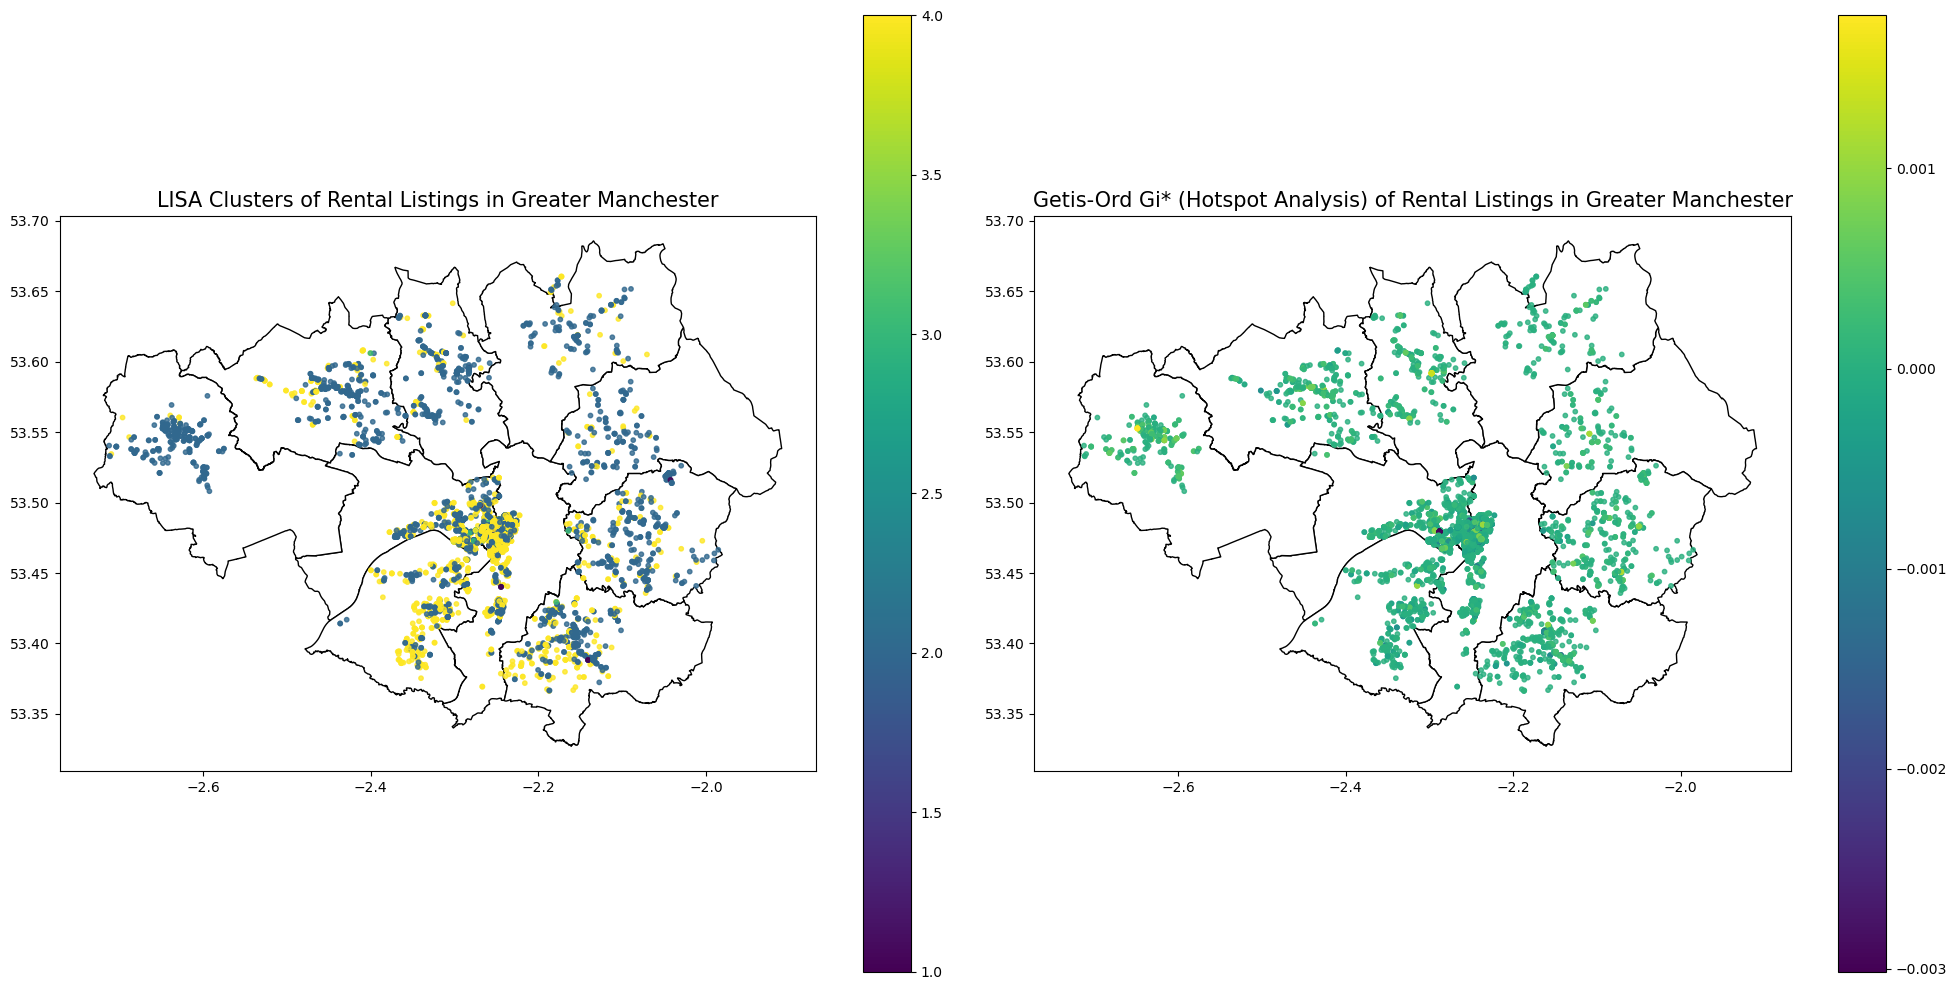

In [9]:
# Create a GeoDataFrame
geometry = [Point(xy) for xy in zip(df['Lng'], df['Lat'])]
gdf_rentals = gpd.GeoDataFrame(df, geometry=geometry, crs="EPSG:4326")

# Log transform rental prices
gdf_rentals['log_rent'] = np.log(gdf_rentals['Asking rent (pm)'])

# Calculate spatial weights matrix using DistanceBand with a threshold of 5000 meters
w_distance = DistanceBand.from_dataframe(gdf_rentals, threshold= 5000, binary=True)

# Compute Moran's I
y = gdf_rentals['log_rent'].values
moran_distance = esda.Moran(y, w_distance)
print(f"Moran's I for log-transformed rents: {moran_distance.I}, p-value: {moran_distance.p_sim}")

# Compute LISA (Local Moran's I)
lisa = esda.Moran_Local(y, w_distance)
gdf_rentals['LISA_cluster'] = lisa.q

# Compute Getis-Ord Gi* statistic
g_star = G_Local(gdf_rentals['log_rent'].values, w_distance)
gdf_rentals['G_star'] = g_star.Zs

# Plotting both LISA and Getis-Ord Gi* on the same figure
fig, ax = plt.subplots(1, 2, figsize=(20, 10))

# Plot the base map of the boroughs
gmcr_boroughs.plot(ax=ax[0], color='white', edgecolor='black')
gmcr_boroughs.plot(ax=ax[1], color='white', edgecolor='black')

# Plot the rental data with LISA cluster categories using 'viridis' colormap
gdf_rentals.plot(column='LISA_cluster', ax=ax[0], cmap='viridis', legend=True, markersize=10, alpha=0.8)
ax[0].set_title('LISA Clusters of Rental Listings in Greater Manchester', fontsize=15)

# Plot the rental data with Gi* Z-scores using 'coolwarm' colormap
gdf_rentals.plot(column='G_star', ax=ax[1], cmap='viridis', legend=True, markersize=10, alpha=0.8)
ax[1].set_title('Getis-Ord Gi* (Hotspot Analysis) of Rental Listings in Greater Manchester', fontsize=15)

plt.tight_layout()
plt.show()


The Moran's I value is close to zero, indicating almost no overall spatial autocorrelation in the log-transformed rental prices data. The slightly negative value suggests a weak tendency towards dispersion, though this effect is minimal. Despite the proximity of the Moran's I value to zero, the very small -. However, the near-zero Moran's I indicates that this non-randomness does not strongly favor either clustering or dispersion. To gain a more localized understanding, we performed a LISA analysis, which revealed areas of both clustering and dispersion. The LISA plot identified significant High-High (HH) clusters, indicating regions where high rental prices are surrounded by other high rental prices, and Low-Low (LL) clusters, where low rental prices are surrounded by other low rental prices. This suggests that certain areas exhibit strong local clustering of similar rental values, which could be driven by localized factors such as proximity to amenities, quality of infrastructure, or socio-economic characteristics. The Getis-Ord Gi* analysis further complemented these findings by identifying hotspots and coldspots. The hotspots (positive Gi* Z-scores) indicate statistically significant clustering of high rental prices, confirming areas of high demand, while coldspots (negative Gi* Z-scores) indicate clustering of low rental prices, which might correlate with less desirable living conditions or fewer amenities. Overall, these analyses demonstrate that while the overall spatial autocorrelation is weak, there are significant local patterns of clustering and dispersion. This localized spatial heterogeneity highlights the importance of considering both global and local spatial analyses in understanding the distribution of rental prices in Greater Manchester

<h4>GEOGRAPHICALLY WEIGHTED REGRESSION</h4>

In [3]:
# Drop the 'Unnamed: 0' column 
if 'Unnamed: 0' in df.columns:
    df.drop(columns=['Unnamed: 0'], inplace=True)

# Rename columns to the specified format
df.rename(columns={
    'distance_to_nearest_good': 'distToNearestSchool(Good)',
    'distance_to_nearest_outstanding': 'distToNearestSchool(Outstanding)',
    'distance_to_nearest_requires_improvement': 'distToNearestSchool(NeedsImprovement)',
    'distance_to_nearest_inadequate': 'distToNearestSchool(Inadequate)',
    'distance_to_nearest_unknown': 'distToNearestSchool(Unknown)',
    'Index of Multiple Deprivation (IMD) Score': 'IndexOfMultipleDeprivationScore'
}, inplace=True)

# Drop original columns to avoid duplicates
original_columns_to_drop = [
    'nearest_good_school',
    'nearest_outstanding_school',
    'nearest_requires_improvement_school',
    'nearest_inadequate_school',
    'nearest_unknown_school',
    'Index of Multiple Deprivation Score'
]
df.drop(columns=original_columns_to_drop, inplace=True, errors='ignore')

# Select relevant columns including Lat and Lng
selected_columns = [
    'Type', 'Bedrooms', 'Asking rent (pm)', 'no_of_unique_lines_200m', 'Lat', 'Lng',
    'no_of_unique_routeids_200m', 'no_of_unique_lines_400m',
    'no_of_unique_routeids_400m', 'nearest_hospital_distance', 'nearest_park_distance',
    'nearest_supermarket_distance', 'nearest_city_center_distance', 'nearest_train_station_distance',
    'distToNearestSchool(Good)', 'distToNearestSchool(Outstanding)', 'distToNearestSchool(NeedsImprovement)',
    'distToNearestSchool(Inadequate)', 'distToNearestSchool(Unknown)', 'IndexOfMultipleDeprivationScore'
]
df_filtered = df[selected_columns].copy()  # Use .copy() to ensure we work with a separate DataFrame

# Handle missing values for numerical columns using median
numerical_cols = df_filtered.select_dtypes(include=['float64', 'int64']).columns
df_filtered[numerical_cols] = df_filtered[numerical_cols].apply(lambda x: x.fillna(x.median()))

# Handle missing values for categorical columns using mode
categorical_cols = df_filtered.select_dtypes(include=['object']).columns
for col in categorical_cols:
    df_filtered[col] = df_filtered[col].fillna(df_filtered[col].mode()[0])

# Ensure Lat and Lng do not have NaNs
df_filtered['Lat'] = df_filtered['Lat'].fillna(df_filtered['Lat'].median())
df_filtered['Lng'] = df_filtered['Lng'].fillna(df_filtered['Lng'].median())

# Ensure there are no NaNs left before encoding
assert df_filtered.isnull().sum().sum() == 0, "There are still NaNs in the data before encoding."

# Encode categorical variables using one-hot encoding
df_encoded = pd.get_dummies(df_filtered, drop_first=True)

# Save original data before transformation for semi-log model
df_semi_log = df_encoded.copy()

# Double-log transformation: Log scale the rent prices and other continuous variables (except dummies and Lat/Lng)
df_encoded['log_price'] = np.log1p(df_encoded['Asking rent (pm)'])
for col in df_encoded.columns:
    if df_encoded[col].dtype in ['float64', 'int64'] and col not in ['log_price', 'Lat', 'Lng']:
        df_encoded[col] = np.log1p(df_encoded[col])

# For semi-log, only log the dependent variable
df_semi_log['log_price'] = np.log1p(df_semi_log['Asking rent (pm)'])

# Drop the original rent price column
df_encoded.drop('Asking rent (pm)', axis=1, inplace=True)
df_semi_log.drop('Asking rent (pm)', axis=1, inplace=True)

# Separate features (X) and target variable (y)
X_double_log = df_encoded.drop('log_price', axis=1)
y_double_log = df_encoded['log_price']

X_semi_log = df_semi_log.drop('log_price', axis=1)
y_semi_log = df_semi_log['log_price']

# Ensure there are no NaNs in the features and target before scaling
assert not X_double_log.isnull().any().any(), "There are NaNs in the features data before scaling."
assert not y_double_log.isnull().any(), "There are NaNs in the target data before scaling."
assert not X_semi_log.isnull().any().any(), "There are NaNs in the features data before scaling."
assert not y_semi_log.isnull().any(), "There are NaNs in the target data before scaling."

# Standardize the features
scaler = StandardScaler()
X_double_log_scaled = scaler.fit_transform(X_double_log)
X_semi_log_scaled = scaler.fit_transform(X_semi_log)

# Ensure there are no NaNs after scaling
assert not np.isnan(X_double_log_scaled).any(), "There are NaNs in the scaled data."
assert not np.isnan(X_semi_log_scaled).any(), "There are NaNs in the scaled data."

# Include Lat and Lng as spatial coordinates for GWR analysis
coords = df_filtered[['Lat', 'Lng']].values




The GWR model, including geographical coordinates, is expressed as:

$$
\ln(P_i) = \beta_0(\phi, \lambda) + \sum_{k=1}^{m} \alpha_k(\phi, \lambda) \text{Property}_{ik} + \sum_{j=1}^{n} \beta_j(\phi, \lambda) \text{Neighborhood}_{ij} + \sum_{l=1}^{p} \gamma_l(\phi, \lambda) \text{Transport}_{il} + \epsilon_i
$$

Here, the coefficients \(\beta_0(\phi, \lambda)\), \(\alpha_k(\phi, \lambda)\), \(\beta_j(\phi, \lambda)\), and \(\gamma_l(\phi, \lambda)\) vary with geographical coordinates \(\phi\) and \(\lambda\) (latitude and longitude), reflecting the varying influence of different attributes across the study area.
y area.
y area.


In [132]:
# Define a range of bandwidths
bandwidth_range = range(2500, 4001, 100)

# Variables to store the best model results for Double-Log and Semi-Log Models
best_aicc_double_log = float('inf')
best_bw_double_log = None
best_results_double_log = None

best_aicc_semi_log = float('inf')
best_bw_semi_log = None
best_results_semi_log = None

# Fitting GWR for Double-Log Model
print("Fitting Double-Log GWR Models...")
for bw in bandwidth_range:
    model_double_log = GWR(coords, y_double_log.values.reshape(-1, 1), X_double_log_scaled, bw)
    results_double_log = model_double_log.fit()
    if results_double_log.aicc < best_aicc_double_log:
        best_aicc_double_log = results_double_log.aicc
        best_bw_double_log = bw
        best_results_double_log = results_double_log

# Fitting GWR for Semi-Log Model
print("\nFitting Semi-Log GWR Models...")
for bw in bandwidth_range:
    model_semi_log = GWR(coords, y_semi_log.values.reshape(-1, 1), X_semi_log_scaled, bw)
    results_semi_log = model_semi_log.fit()
    if results_semi_log.aicc < best_aicc_semi_log:
        best_aicc_semi_log = results_semi_log.aicc
        best_bw_semi_log = bw
        best_results_semi_log = results_semi_log

# Print best model results for Double-Log
print("\nDouble-Log GWR Model Summary")
print(f"Best AICc: {best_aicc_double_log}")
print(f"Optimal bandwidth: {best_bw_double_log}")
print(best_results_double_log.summary())

# Print best model results for Semi-Log
print("\nSemi-Log GWR Model Summary")
print(f"Best AICc: {best_aicc_semi_log}")
print(f"Optimal bandwidth: {best_bw_semi_log}")
print(best_results_semi_log.summary())


Fitting Double-Log GWR Models...

Fitting Semi-Log GWR Models...

Double-Log GWR Model Summary
Best AICc: -2762.9285708058464
Optimal bandwidth: 2500
Model type                                                         Gaussian
Number of observations:                                                5703
Number of covariates:                                                    22

Global Regression Results
---------------------------------------------------------------------------
Residual sum of squares:                                            264.376
Log-likelihood:                                                     665.822
AIC:                                                              -1287.644
AICc:                                                             -1285.449
BIC:                                                             -48869.159
R2:                                                                   0.552
Adj. R2:                                                       

<h4> LINEAR REGRESSION <h4>


**Functional Forms**

**Double-Log Model:**

In a double-log model, both the dependent variable and the independent variables are log-transformed. The equation is represented as:

$$
\ln(Y) = \beta_0 + \beta_1\ln(X_1) + \beta_2\ln(X_2) + \dots + \beta_n\ln(X_n) + \epsilon
$$

Where:
- \( \ln(Y) \) is the natural logarithm of the dependent variable.
- \( \ln(X_i) \) are the natural logarithms of the independent variables.
- \( \beta_i \) are the coefficients.
- \( \epsilon \) is the error term.

**Semi-Log Model:**

In a semi-log model, either the dependent variable or the independent variables are log-transformed. For instance, if only the dependent variable is log-transformed, the model is represented as:

$$
\ln(Y) = \beta_0 + \beta_1X_1 + \beta_2X_2 + \dots + \beta_nX_n + \epsilon
$$

Where:
- \( \ln(Y) \) is the natural logarithm of the dependent variable.
- \( X_i \) are the independent variables.
- \( \beta_i \) are the coefficients.
- \( \epsilon \) is the error term.

These equations allow us to interpret the coefficients in terms of percentage changes, which is particularly useful for economic and financial data. The semi-log model, due to its better fit and lower error, is chosen for the detailed analysis in this study.


In [ ]:
#Preprocessing for models other than GWR ie without inclusion of latitude and longitude
# Drop the 'Unnamed: 0' column 
if 'Unnamed: 0' in df.columns:
    df.drop(columns=['Unnamed: 0'], inplace=True)

# Rename columns to the specified format
df.rename(columns={
    'distance_to_nearest_good': 'distToNearestSchool(Good)',
    'distance_to_nearest_outstanding': 'distToNearestSchool(Outstanding)',
    'distance_to_nearest_requires_improvement': 'distToNearestSchool(NeedsImprovement)',
    'distance_to_nearest_inadequate': 'distToNearestSchool(Inadequate)',
    'distance_to_nearest_unknown': 'distToNearestSchool(Unknown)',
    'Index of Multiple Deprivation (IMD) Score': 'IndexOfMultipleDeprivationScore'
}, inplace=True)

# Drop original columns to avoid duplicates
original_columns_to_drop = [
    'nearest_good_school',
    'nearest_outstanding_school',
    'nearest_requires_improvement_school',
    'nearest_inadequate_school',
    'nearest_unknown_school',
    'Index of Multiple Deprivation Score'
]
df.drop(columns=original_columns_to_drop, inplace=True, errors='ignore')
# Select relevant columns
selected_columns = [
    'Type', 'Bedrooms', 'Asking rent (pm)', 'no_of_unique_lines_200m',
    'no_of_unique_routeids_200m', 'no_of_unique_lines_400m',
    'no_of_unique_routeids_400m', 'nearest_hospital_distance', 'nearest_park_distance',
    'nearest_supermarket_distance', 'nearest_city_center_distance', 'nearest_train_station_distance',
    'distToNearestSchool(Good)', 'distToNearestSchool(Outstanding)', 'distToNearestSchool(NeedsImprovement)',
    'distToNearestSchool(Inadequate)', 'distToNearestSchool(Unknown)', 'IndexOfMultipleDeprivationScore'
]
df_filtered = df[selected_columns]

# Handle missing values
numerical_cols = df_filtered.select_dtypes(include=['float64', 'int64']).columns
df_filtered[numerical_cols] = df_filtered[numerical_cols].apply(lambda x: x.fillna(x.median()))

categorical_cols = df_filtered.select_dtypes(include=['object']).columns
df_filtered[categorical_cols] = df_filtered[categorical_cols].apply(lambda x: x.fillna(x.mode()[0]))

# Ensure there are no NaNs left
assert df_filtered.isnull().sum().sum() == 0, "There are still NaNs in the data."



<h5> Double Log <h5>

In [4]:
# Encode categorical variables using one-hot encoding
df_encoded = pd.get_dummies(df_filtered, drop_first=True)

# Double-log transformation: Log scale the rent prices and independent variables (except dummies)
df_encoded['log_price'] = np.log1p(df_encoded['Asking rent (pm)'])

# Apply log transformation to continuous independent variables
for col in df_encoded.columns:
    if df_encoded[col].dtype in ['float64', 'int64'] and col != 'log_price':
        df_encoded[col] = np.log1p(df_encoded[col])

# Drop the original rent price column
df_encoded.drop('Asking rent (pm)', axis=1, inplace=True)

# Separate features (X) and target variable (y)
X = df_encoded.drop('log_price', axis=1)
y = df_encoded['log_price']

# Standardize the features
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Ensure there are no NaNs after scaling
assert not np.isnan(X_scaled).any(), "There are NaNs in the scaled data."

# Split data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.2, random_state=42)

# Bayesian Optimization for Linear Regression
param_space_lr = [
    Real(1e-6, 1e-2, "log-uniform", name="alpha")
]

@use_named_args(param_space_lr)
def objective_lr(alpha):
    model = LinearRegression()
    return -np.mean(cross_val_score(model, X_train, y_train, cv=5, n_jobs=-1, scoring="neg_mean_squared_error"))

# Run Bayesian optimization to find the best parameters
res_gp_lr = gp_minimize(objective_lr, param_space_lr, n_calls=50, random_state=42, verbose=True, n_jobs=10)
print("Best parameters for Linear Regression: ", res_gp_lr.x)
best_params_lr = {name: value for name, value in zip([d.name for d in param_space_lr], res_gp_lr.x)}

# Train the Linear Regression model with the best parameters using scikit-learn
model_lr = LinearRegression()
model_lr.fit(X_train, y_train)

# Predict on the test set
y_pred_lr = model_lr.predict(X_test)

# Convert predictions and actual values back to the original scale
y_pred_orig_scale_lr = np.expm1(y_pred_lr)  # Convert predictions back to original scale
y_test_orig_scale = np.expm1(y_test)  # Convert the test target variable back to original scale

# Evaluate the model performance
mse_lr = mean_squared_error(y_test_orig_scale, y_pred_orig_scale_lr)
r2_lr = r2_score(y_test_orig_scale, y_pred_orig_scale_lr)
print(f"Mean Squared Error (Linear Regression): {mse_lr}")
print(f"R2 score (Linear Regression): {r2_lr}")

Iteration No: 1 started. Evaluating function at random point.
Iteration No: 1 ended. Evaluation done at random point.
Time taken: 3.2007
Function value obtained: 0.0482
Current minimum: 0.0482
Iteration No: 2 started. Evaluating function at random point.
Iteration No: 2 ended. Evaluation done at random point.
Time taken: 1.5849
Function value obtained: 0.0482
Current minimum: 0.0482
Iteration No: 3 started. Evaluating function at random point.
Iteration No: 3 ended. Evaluation done at random point.
Time taken: 0.0320
Function value obtained: 0.0482
Current minimum: 0.0482
Iteration No: 4 started. Evaluating function at random point.
Iteration No: 4 ended. Evaluation done at random point.
Time taken: 0.0313
Function value obtained: 0.0482
Current minimum: 0.0482
Iteration No: 5 started. Evaluating function at random point.
Iteration No: 5 ended. Evaluation done at random point.
Time taken: 0.0160
Function value obtained: 0.0482
Current minimum: 0.0482
Iteration No: 6 started. Evaluating

In [5]:
# Predict on the test set
y_pred_lr = model_lr.predict(X_test)

# Convert predictions and actual values back to the original scale
y_pred_orig_scale_lr = np.expm1(y_pred_lr)  # Convert predictions back to original scale
y_test_orig_scale = np.expm1(y_test)  # Convert the test target variable back to original scale

# Evaluate the model performance
mse_lr = mean_squared_error(y_test_orig_scale, y_pred_orig_scale_lr)
r2_lr = r2_score(y_test_orig_scale, y_pred_orig_scale_lr)
print(f"Mean Squared Error (Linear Regression): {mse_lr}")
print(f"R2 score (Linear Regression): {r2_lr}")

Mean Squared Error (Linear Regression): 75934.97742631895
R2 score (Linear Regression): 0.5549520811587512


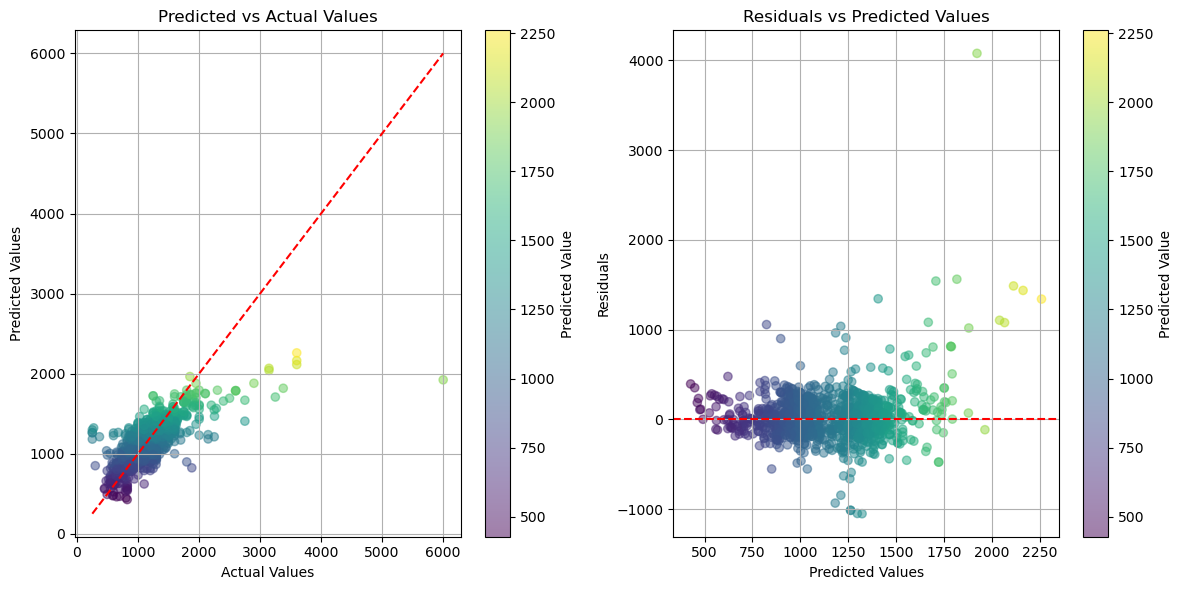

In [6]:
# Create a range of colors based on predicted values
colors = y_pred_orig_scale_lr

# Predicted vs Actual Plot
plt.figure(figsize=(12, 6))

# Plot 1: Predicted vs Actual Values
plt.subplot(1, 2, 1)
plt.scatter(y_test_orig_scale, y_pred_orig_scale_lr, c=colors, cmap='viridis', alpha=0.5)
plt.plot([min(y_test_orig_scale), max(y_test_orig_scale)], 
         [min(y_test_orig_scale), max(y_test_orig_scale)], 
         'r', linestyle='--')
plt.xlabel('Actual Values')
plt.ylabel('Predicted Values')
plt.title('Predicted vs Actual Values')
plt.colorbar(label='Predicted Value')
plt.grid(True)

# Plot 2: Residual Plot
plt.subplot(1, 2, 2)
residuals = y_test_orig_scale - y_pred_orig_scale_lr
plt.scatter(y_pred_orig_scale_lr, residuals, c=colors, cmap='viridis', alpha=0.5)
plt.axhline(y=0, color='r', linestyle='--')
plt.xlabel('Predicted Values')
plt.ylabel('Residuals')
plt.title('Residuals vs Predicted Values')
plt.colorbar(label='Predicted Value')
plt.grid(True)

plt.tight_layout()
plt.show()


<h5> Semi Log <h5>

In [9]:
# Suppress specific warning messages
warnings.filterwarnings("ignore", category=UserWarning)

# Encode categorical variables using one-hot encoding
df_encoded = pd.get_dummies(df_filtered, drop_first=True)

# Semi-log transformation: Log scale the rent prices
df_encoded['log_price'] = np.log1p(df_encoded['Asking rent (pm)'])

# Drop the original rent price column
df_encoded.drop('Asking rent (pm)', axis=1, inplace=True)

# Separate features (X) and target variable (y)
X = df_encoded.drop('log_price', axis=1)
y = df_encoded['log_price']

# Standardize the features
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Ensure there are no NaNs after scaling
assert not np.isnan(X_scaled).any(), "There are NaNs in the scaled data."

# Split data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.2, random_state=42)

# Bayesian Optimization for Linear Regression
param_space_lr = [
    Real(1e-6, 1e-2, "log-uniform", name="alpha")
]

@use_named_args(param_space_lr)
def objective_lr(alpha):
    model = LinearRegression()
    return -np.mean(cross_val_score(model, X_train, y_train, cv=5, n_jobs=-1, scoring="neg_mean_squared_error"))

# Run Bayesian optimization to find the best parameters
res_gp_lr = gp_minimize(objective_lr, param_space_lr, n_calls=50, random_state=42, verbose=True, n_jobs=10)
print("Best parameters for Linear Regression: ", res_gp_lr.x)
best_params_lr = {name: value for name, value in zip([d.name for d in param_space_lr], res_gp_lr.x)}

# Train the Linear Regression model with the best parameters using scikit-learn
model_lr = LinearRegression()
model_lr.fit(X_train, y_train)

# Predict on the test set
y_pred_lr = model_lr.predict(X_test)

# Convert predictions and actual values back to the original scale
y_pred_orig_scale_lr = np.expm1(y_pred_lr)  # Convert predictions back to original scale
y_test_orig_scale = np.expm1(y_test)  # Convert the test target variable back to original scale

# Evaluate the model performance
mse_lr = mean_squared_error(y_test_orig_scale, y_pred_orig_scale_lr)
r2_lr = r2_score(y_test_orig_scale, y_pred_orig_scale_lr)
print(f"Mean Squared Error (Linear Regression): {mse_lr}")
print(f"R2 score (Linear Regression): {r2_lr}")

Iteration No: 1 started. Evaluating function at random point.
Iteration No: 1 ended. Evaluation done at random point.
Time taken: 1.1752
Function value obtained: 0.0426
Current minimum: 0.0426
Iteration No: 2 started. Evaluating function at random point.
Iteration No: 2 ended. Evaluation done at random point.
Time taken: 1.8939
Function value obtained: 0.0426
Current minimum: 0.0426
Iteration No: 3 started. Evaluating function at random point.
Iteration No: 3 ended. Evaluation done at random point.
Time taken: 0.0301
Function value obtained: 0.0426
Current minimum: 0.0426
Iteration No: 4 started. Evaluating function at random point.
Iteration No: 4 ended. Evaluation done at random point.
Time taken: 0.0326
Function value obtained: 0.0426
Current minimum: 0.0426
Iteration No: 5 started. Evaluating function at random point.
Iteration No: 5 ended. Evaluation done at random point.
Time taken: 0.0146
Function value obtained: 0.0426
Current minimum: 0.0426
Iteration No: 6 started. Evaluating

In [10]:
# Predict on the test set
y_pred_lr = model_lr.predict(X_test)

# Convert predictions and actual values back to the original scale
y_pred_orig_scale_lr = np.expm1(y_pred_lr)  # Convert predictions back to original scale
y_test_orig_scale = np.expm1(y_test)  # Convert the test target variable back to original scale

# Evaluate the model performance
mse_lr = mean_squared_error(y_test_orig_scale, y_pred_orig_scale_lr)
r2_lr = r2_score(y_test_orig_scale, y_pred_orig_scale_lr)
print(f"Mean Squared Error (Linear Regression): {mse_lr}")
print(f"R2 score (Linear Regression): {r2_lr}")

Mean Squared Error (Linear Regression): 55214.487975492266
R2 score (Linear Regression): 0.6763929641353789


In [11]:


# Assuming X_scaled and y are your feature matrix and target variable
X_const = sm.add_constant(X_scaled)
model = sm.OLS(y, X_const)
results = model.fit()

# Get the summary DataFrame
summary_df = results.summary2().tables[1]

# Print the coefficients with p-values
print("Linear Regression Coefficients with p-values:")
for index, row in summary_df.iterrows():
    coef = row['Coef.']
    p_value = row['P>|t|']
    print(f"{index}: Coefficient = {coef:.4f}, p-value = {p_value:.4f}")


Linear Regression Coefficients with p-values:
const: Coefficient = 7.0340, p-value = 0.0000
x1: Coefficient = 0.2366, p-value = 0.0000
x2: Coefficient = -0.0062, p-value = 0.2112
x3: Coefficient = 0.0041, p-value = 0.5077
x4: Coefficient = -0.0067, p-value = 0.2405
x5: Coefficient = 0.0256, p-value = 0.0001
x6: Coefficient = -0.0138, p-value = 0.0000
x7: Coefficient = 0.0056, p-value = 0.0616
x8: Coefficient = -0.0103, p-value = 0.0043
x9: Coefficient = -0.0352, p-value = 0.0000
x10: Coefficient = -0.0538, p-value = 0.0000
x11: Coefficient = 0.0159, p-value = 0.0000
x12: Coefficient = -0.0056, p-value = 0.0659
x13: Coefficient = 0.0234, p-value = 0.0000
x14: Coefficient = -0.0356, p-value = 0.0000
x15: Coefficient = -0.0470, p-value = 0.0000
x16: Coefficient = -0.0317, p-value = 0.0000
x17: Coefficient = 0.0711, p-value = 0.0000
x18: Coefficient = 0.0171, p-value = 0.0000
x19: Coefficient = -0.0037, p-value = 0.3375



FUNCTIONAL FORM SELECTION 

To evaluate the performance of the semi-log and double-log models, we compared their Mean Squared Error (MSE) and R² scores:

- **Semi-Log Model:**
  - Mean Squared Error (MSE): 55214.49
  - R² score: 0.6764

- **Double-Log Model:**
  - Mean Squared Error (MSE): 75934.98
  - R² score: 0.5550

The semi-log model exhibits a lower MSE and a higher R² score than the double-log model, indicating that it provides a better fit to the data and has superior predictive performance. Therefore, we select the semi-log model for further analysis.



<h4>  CHECKING FOR MULTICOLLINEARITY USING VIFS <h4>

In [7]:
#VIF Multicollinearity 
# If you haven't already, convert the scaled data back to a DataFrame for easier handling
X_scaled_df = pd.DataFrame(X_scaled, columns=X.columns)
# Calculate VIF for each feature
vif_data = pd.DataFrame()
vif_data['Feature'] = X_scaled_df.columns
vif_data['VIF'] = [variance_inflation_factor(X_scaled_df.values, i) for i in range(X_scaled_df.shape[1])]
print(vif_data)

                                  Feature       VIF
0                                Bedrooms  1.500790
1                 no_of_unique_lines_200m  3.363159
2              no_of_unique_routeids_200m  5.084693
3                 no_of_unique_lines_400m  4.396761
4              no_of_unique_routeids_400m  5.935840
5               nearest_hospital_distance  1.284461
6                   nearest_park_distance  1.195753
7            nearest_supermarket_distance  1.745885
8            nearest_city_center_distance  3.443811
9          nearest_train_station_distance  2.257761
10              distToNearestSchool(Good)  1.337572
11       distToNearestSchool(Outstanding)  1.246608
12  distToNearestSchool(NeedsImprovement)  1.525307
13        distToNearestSchool(Inadequate)  3.726973
14           distToNearestSchool(Unknown)  4.350252
15        IndexOfMultipleDeprivationScore  1.182068
16                              Type_Flat  3.293399
17               Type_Semi-detached house  1.849541
18          

<h5> As most of the VIF values are less than 6, there is not much multicollinearity among the predictor variables <h4>

<h4> CHECKING FOR HETEROSCEDASTICITY USING BREUSCH-PAGAN TEST <h4>

In [8]:

# Fit the model using statsmodels for diagnostic testing
model_stats = sm.OLS(y_train, sm.add_constant(X_train)).fit()
# Get the residuals from the fitted model
residuals = model_stats.resid

# Perform Breusch-Pagan test
bp_test = het_breuschpagan(residuals, model_stats.model.exog)
labels = ['Lagrange multiplier statistic', 'p-value', 'f-value', 'f p-value']
results = dict(zip(labels, bp_test))

print('Breusch-Pagan test results:')
for key, value in results.items():
    print(f'{key}: {value}')


Breusch-Pagan test results:
Lagrange multiplier statistic: 347.99994705631315
p-value: 2.6451169073898953e-62
f-value: 19.741410082573083
f p-value: 5.2386200599221895e-65



The p-value (2.63e-62) is extremely low, significantly below conventional significance levels such as 0.05, 0.01, or even 0.001. This result provides strong evidence to reject the null hypothesis of homoscedasticity (constant variance). Consequently, there is substantial evidence indicating the presence of heteroscedasticity in the residuals of the model 

The Lagrange multiplier statistic is also notably high, reinforcing the indication of heteroscedasticity. Similarly, the f-value and its corresponding p-value align with the findings of the Lagrange multiplier test, further rejecting the null hypothesis of homoscedastici .

In conclusion, the analysis confirms the presence of heteroscedasticity in the model's residuals, indicating that the variance is not constant across observati</h6>


<h4>  HETEROSCEDASTICITY ADJUSTED OLS COEFFICIENTS
    <h4>

In [9]:
# Separate features (X) and target variable (y)
X = df_encoded.drop('log_price', axis=1)
y = df_encoded['log_price']

# Standardize the features
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Ensure there are no NaNs after scaling
assert not np.isnan(X_scaled).any(), "There are NaNs in the scaled data."

# Split data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.2, random_state=42)

# Fit the model using statsmodels with HC3 for heteroskedasticity-consistent standard errors
X_train_const = sm.add_constant(X_train)  # Add a constant term for the intercept
model_stats = sm.OLS(y_train, X_train_const).fit(cov_type='HC3')

# Get the heteroskedasticity-consistent standard errors
hc_se = model_stats.bse

# Predict on the test set
X_test_const = sm.add_constant(X_test)
y_pred_robust = model_stats.predict(X_test_const)

# Convert predictions and actual values back to the original scale
y_pred_orig_scale = np.expm1(y_pred_robust)
y_test_orig_scale = np.expm1(y_test)

# Evaluate the model performance
mse_robust = mean_squared_error(y_test_orig_scale, y_pred_orig_scale)
r2_robust = r2_score(y_test_orig_scale, y_pred_orig_scale)

print(f"Mean Squared Error (Robust Model): {mse_robust}")
print(f"R2 score (Robust Model): {r2_robust}")

# Summary of the robust model
robust_summary = model_stats.summary()

# Display the summary
print(robust_summary)


Mean Squared Error (Robust Model): 55214.48797549355
R2 score (Robust Model): 0.6763929641353714
                            OLS Regression Results                            
Dep. Variable:              log_price   R-squared:                       0.590
Model:                            OLS   Adj. R-squared:                  0.588
Method:                 Least Squares   F-statistic:                     356.3
Date:                Sat, 27 Jul 2024   Prob (F-statistic):               0.00
Time:                        13:03:27   Log-Likelihood:                 749.32
No. Observations:                4562   AIC:                            -1459.
Df Residuals:                    4542   BIC:                            -1330.
Df Model:                          19                                         
Covariance Type:                  HC3                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
----------------------------------

The regression results, adjusted for heteroskedasticity using HC3 consistent standard errors, indicate the robustness of the coefficient estimates. The use of heteroskedasticity-consistent standard errors is crucial, as the Breusch-Pagan test previously revealed significant heteroskedasticity in the residuals, which could lead to inefficient estimates and underestimated standard errors if uncorrected. By employing HC3 standard errors, we ensure more reliable statistical inferences. The table above displays the regression coefficients alongside their heteroskedasticity-consistent standard errors. The significance levels of the coefficients are indicated by the p-values, providing insight into the factors significantly impacting the log-transformed rental prices. Additionally, the Mean Squared Error (MSE) and R-squared (R²) values for the robust model are provided, demonstrating the model's performance. The MSE indicates the average squared difference between the actual and predicted values, while the R² score measures the proportion of variance in the dependent variable explained by the model. The robust R² score of 0.676 suggests that approximately 67.6% of the variance in log-transformed rental prices is explained by the independent variables in the model. Overall, adjusting for heteroskedasticity ensures that our statistical conclusions are not biased due to the presence of non-constant variance [^1] in the error terms, providing a more accurate and reliable analysis of the factors influencing rental prices in Greater Manchester. 


[1] Gingerich, K., Maoh, H. and Anderson, W., 2013. Location and Transportation Effects on Nonresidential Real Estate Price Regressions in Windsor, Ontario, Canada. Transportation research record, 2397(1), pp.99-107.


Shapiro-Wilk Test Statistic: 0.8628458380699158
p-value: 2.008476355046611e-30
Residuals are not normally distributed (reject H0).


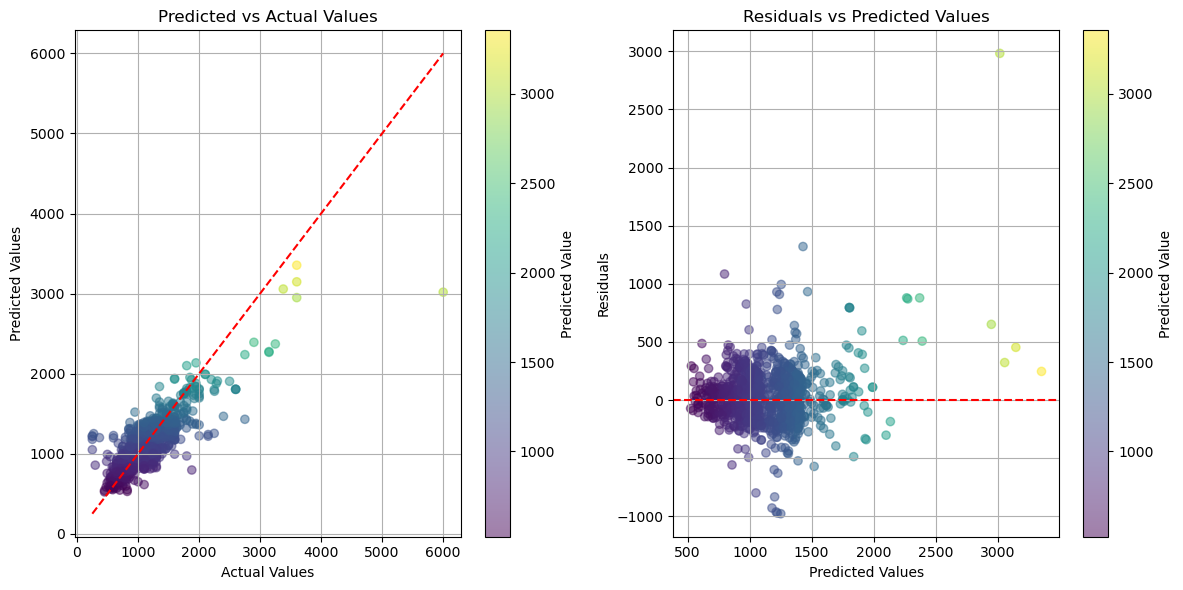

In [47]:
residuals = y_test_orig_scale - y_pred_orig_scale_lr

# Perform the Shapiro-Wilk test
stat, p_value = shapiro(residuals)
print(f"Shapiro-Wilk Test Statistic: {stat}")
print(f"p-value: {p_value}")
if p_value > 0.05:
    print("Residuals are normally distributed (fail to reject H0).")
else:
    print("Residuals are not normally distributed (reject H0).")

# Plotting Predicted vs Actual Values and Residuals
plt.figure(figsize=(12, 6))

# Plot 1: Predicted vs Actual Values
plt.subplot(1, 2, 1)
colors = y_pred_orig_scale_lr  # Color based on predicted values
plt.scatter(y_test_orig_scale, y_pred_orig_scale_lr, c=colors, cmap='viridis', alpha=0.5)
plt.plot([min(y_test_orig_scale), max(y_test_orig_scale)], 
         [min(y_test_orig_scale), max(y_test_orig_scale)], 
         'r', linestyle='--')
plt.xlabel('Actual Values')
plt.ylabel('Predicted Values')
plt.title('Predicted vs Actual Values')
plt.colorbar(label='Predicted Value')
plt.grid(True)

# Plot 2: Residual Plot
plt.subplot(1, 2, 2)
plt.scatter(y_pred_orig_scale_lr, residuals, c=colors, cmap='viridis', alpha=0.5)
plt.axhline(y=0, color='r', linestyle='--')
plt.xlabel('Predicted Values')
plt.ylabel('Residuals')
plt.title('Residuals vs Predicted Values')
plt.colorbar(label='Predicted Value')
plt.grid(True)

plt.tight_layout()
plt.show()



The Shapiro-Wilk test results and the residual plots provide important insights into the distribution and behavior of residuals in our regression model.

- **Shapiro-Wilk Test Statistic**: 0.8628458380699158
- **p-value**: 2.00847535894611e-30

The p-value is significantly less than 0.05, leading us to reject the null hypothesis (H0) that the residuals are normally distributed. This indicates that the residuals do not follow a normal distribution.
 luded in the model.
 <h4>

<h3> QUANTILE REGESSION <h3>

In [48]:
# Define your feature matrix X and target vector y
X = df_encoded.drop(['log_price'], axis=1)
y = df_encoded['log_price']

# Standardize the features
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Add a constant term for the intercept
X_const = sm.add_constant(X_scaled)

# Define the quantiles to study
quantiles = [0.1, 0.5, 0.9]

# Store results
results = {}

for q in quantiles:
    # Fit Quantile Regression model
    model = QuantReg(y, X_const)
    res = model.fit(q=q)
    results[q] = res

    # Print the quantile regression results
    print(f"\nQuantile Regression at {q*100}th percentile:")
    print(res.summary())

    # Extract and print the coefficients
    coeffs = res.params
    coeff_names = X.columns.tolist()
    coeff_names = ['const'] + coeff_names  # Add the constant term
    print("\nCoefficients:")
    for name, coef in zip(coeff_names, coeffs):
        print(f"{name}: {coef:.4f}")




Quantile Regression at 10.0th percentile:
                         QuantReg Regression Results                          
Dep. Variable:              log_price   Pseudo R-squared:               0.4155
Model:                       QuantReg   Bandwidth:                     0.03622
Method:                 Least Squares   Sparsity:                       0.8136
Date:                Mon, 29 Jul 2024   No. Observations:                 5703
Time:                        14:56:40   Df Residuals:                     5683
                                        Df Model:                           19
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          6.8258      0.003   2096.199      0.000       6.819       6.832
x1             0.2125      0.004     50.349      0.000       0.204       0.221
x2            -0.0040      0.006     -0.670      0.503      -0.016       0.008
x3       

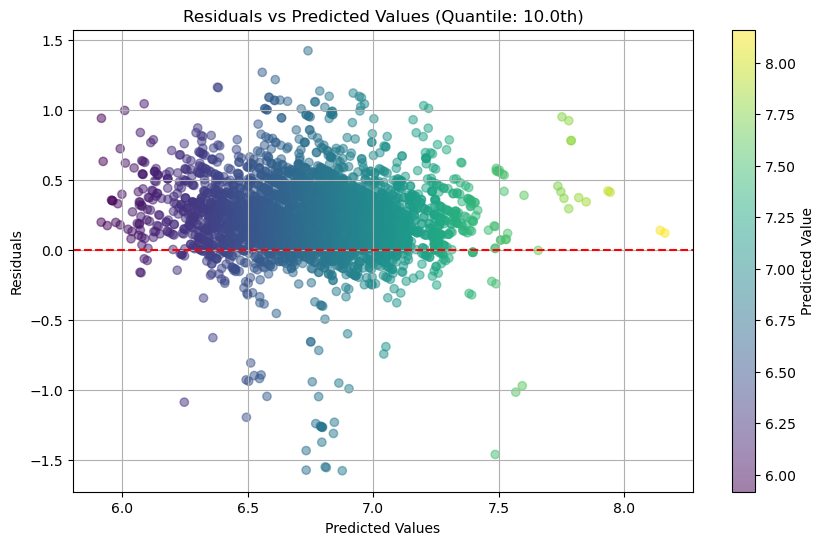

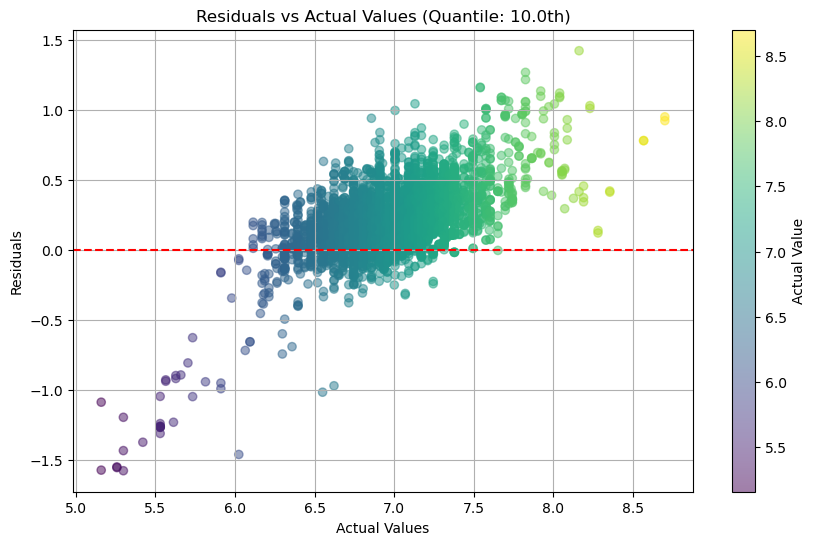

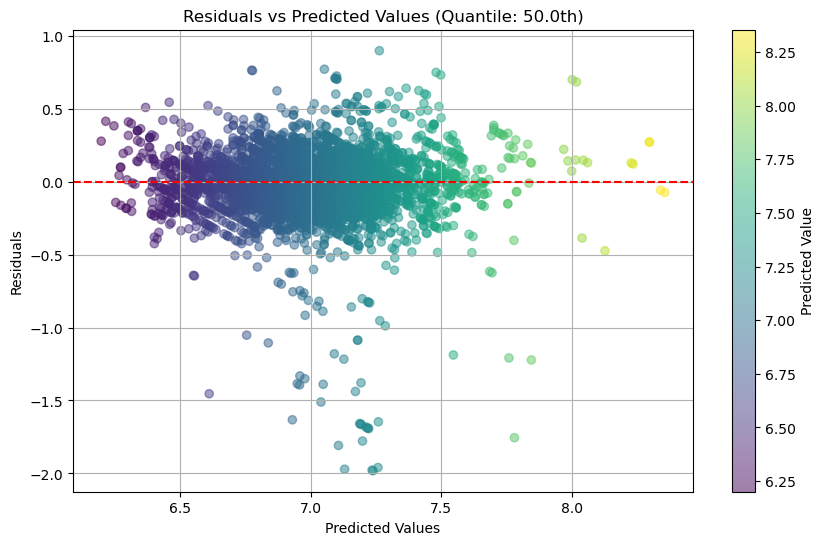

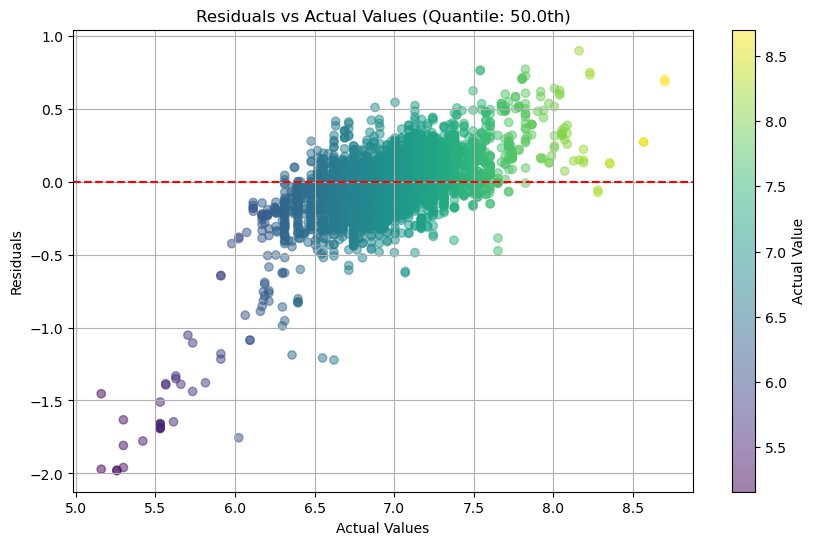

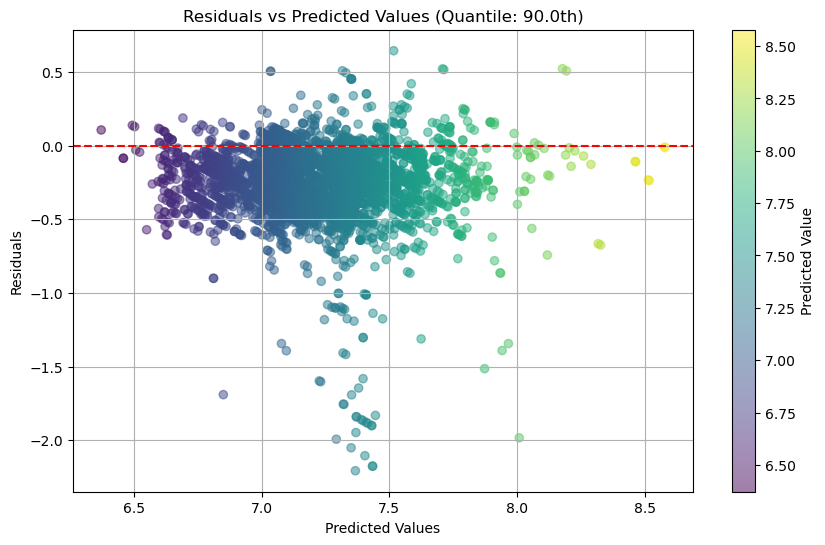

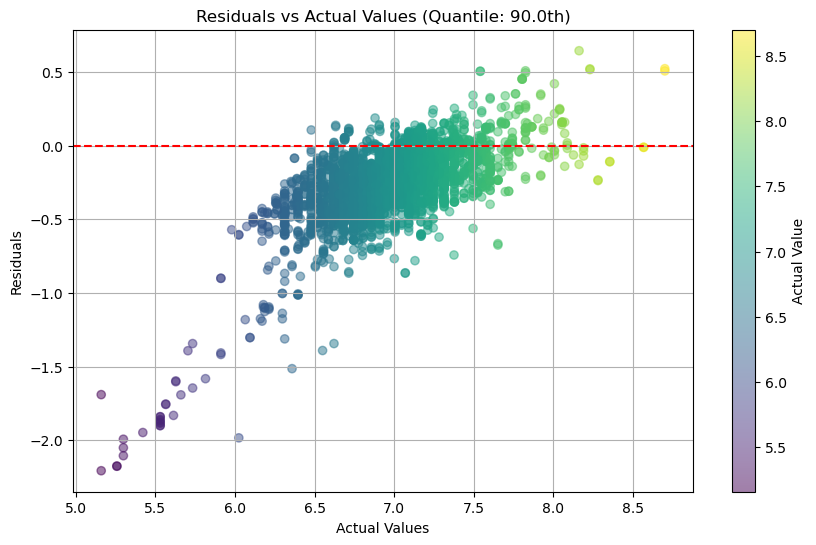

In [50]:
#checking residuals for quantile regression 
for q, res in results.items():
    # Predict the values
    y_pred = res.predict(X_const)
    
    # Compute residuals
    residuals = y - y_pred

    # Plot residuals vs predicted values
    plt.figure(figsize=(10, 6))
    plt.scatter(y_pred, residuals, c=y_pred, cmap='viridis', alpha=0.5)
    plt.axhline(y=0, color='r', linestyle='--')
    plt.xlabel('Predicted Values')
    plt.ylabel('Residuals')
    plt.title(f'Residuals vs Predicted Values (Quantile: {q*100}th)')
    plt.colorbar(label='Predicted Value')
    plt.grid(True)
    plt.show()

    # Plot residuals vs actual values
    plt.figure(figsize=(10, 6))
    plt.scatter(y, residuals, c=y, cmap='viridis', alpha=0.5)
    plt.axhline(y=0, color='r', linestyle='--')
    plt.xlabel('Actual Values')
    plt.ylabel('Residuals')
    plt.title(f'Residuals vs Actual Values (Quantile: {q*100}th)')
    plt.colorbar(label='Actual Value')
    plt.grid(True)
    plt.show()





**Residuals vs Predicted Values (Quantile: 10.0th) and Residuals vs Actual Values (Quantile: 10.0th)**

In the first pair of plots for the 10th quantile, we observe the following:
- **Residuals vs Predicted Values**: The residuals are spread relatively evenly around the zero line, but there is some heteroskedasticity visible, as the spread increases with the predicted values. This indicates that the model may not capture the variability of the lower end of rental prices very well.
- **Residuals vs Actual Values**: Similar to the residuals vs predicted values plot, there is an increasing spread of residuals with the actual values, suggesting potential issues with capturing the true variability at the lower end of the distribution.

**Residuals vs Predicted Values (Quantile: 50.0th) and Residuals vs Actual Values (Quantile: 50.0th)**

For the median quantile (50th), we notice:
- **Residuals vs Predicted Values**: The residuals are more tightly clustered around the zero line, showing a better fit of the model for the median rental prices. However, some heteroskedasticity remains, as indicated by the increasing spread of residuals with higher predicted values.
- **Residuals vs Actual Values**: The plot also indicates a tighter clustering of residuals around the zero line, showing a reasonably good model fit for the median rental prices. The pattern of heteroskedasticity persists, albeit less pronounced than in the lower quantile


- **Heteroskedasticity**: Across all quantiles, there is evidence of heteroskedasticity, where the spread of residuals increases with higher values. This suggests that the variability in rental prices is not constant and increases for higher rental prices.
- **Model Fit**: The residuals are centered around the zero line, indicating that the model does not systematically overestimate or underestimate rental prices. However, the spread of residuals shows that there are variations that the model does not fully capture, particularly for higher rental prices.
- **Quantile Differences**: The spread of residuals varies across quantiles, indicating that different quantile regressions capture different aspects of the rental price distribution. The median quantile (50th) shows a tighter fit compared to the lower quantile (10th), suggesting a better model fit for the central tendency of the data.



The quantile regression analysis highlights that while the model captures the central tendency (median) of rental prices reasonably well, it struggles to account for the variability at the lower and upper ends of the distribution. The presence of heteroskedasticity suggests that further refinement of the model, possibly incorporating more predictors or different modeling techniques, could help improve the fit and capture the variability in rental prices more accurately.
more accurately.
 <h6>

<h3> RANDOM FOREST WITH BAYESIAN OPTIMIZATION <h3>

In [12]:
# Define the parameter space for Bayesian optimization
param_space_rf = [
    Integer(100, 500, name="n_estimators"),
    Integer(3, 15, name="max_depth"),
    Integer(2, 10, name="min_samples_split"),
    Integer(1, 10, name="min_samples_leaf"),
    Real(0.1, 1.0, name="max_features")
]

# Define the objective function for Bayesian optimization
@use_named_args(param_space_rf)
def objective_rf(**params):
    model = RandomForestRegressor(random_state=42, **params)
    return -np.mean(cross_val_score(model, X_train, y_train, cv=5, n_jobs=-1, scoring="neg_mean_squared_error"))

# Run Bayesian optimization
res_gp_rf = gp_minimize(objective_rf, param_space_rf, n_calls=50, random_state=42, verbose=True, n_jobs=-1)
print("Best parameters for Random Forest: ", res_gp_rf.x)
best_params_rf = {name: value for name, value in zip([d.name for d in param_space_rf], res_gp_rf.x)}

# Train the model with the best parameters
model_rf = RandomForestRegressor(random_state=42, **best_params_rf)
model_rf.fit(X_train, y_train)

# Predict and evaluate
y_pred_rf = model_rf.predict(X_test)
y_test_orig_scale = np.expm1(y_test)  # Convert test values back to original scale if log-transformed
y_pred_orig_scale_rf = np.expm1(y_pred_rf)  # Convert predictions back to original scale

mse_rf = mean_squared_error(y_test_orig_scale, y_pred_orig_scale_rf)
r2_rf = r2_score(y_test_orig_scale, y_pred_orig_scale_rf)
print(f"Mean Squared Error (RF): {mse_rf}")
print(f"R2 score (RF): {r2_rf}")



Iteration No: 1 started. Evaluating function at random point.
Iteration No: 1 ended. Evaluation done at random point.
Time taken: 6.8306
Function value obtained: 0.0415
Current minimum: 0.0415
Iteration No: 2 started. Evaluating function at random point.
Iteration No: 2 ended. Evaluation done at random point.
Time taken: 5.7247
Function value obtained: 0.0270
Current minimum: 0.0270
Iteration No: 3 started. Evaluating function at random point.
Iteration No: 3 ended. Evaluation done at random point.
Time taken: 6.0196
Function value obtained: 0.0246
Current minimum: 0.0246
Iteration No: 4 started. Evaluating function at random point.
Iteration No: 4 ended. Evaluation done at random point.
Time taken: 9.4878
Function value obtained: 0.0253
Current minimum: 0.0246
Iteration No: 5 started. Evaluating function at random point.
Iteration No: 5 ended. Evaluation done at random point.
Time taken: 1.5676
Function value obtained: 0.0604
Current minimum: 0.0246
Iteration No: 6 started. Evaluating


The Random Forest model was optimized using Bayesian optimization. The goal was to identify the best set of hyperparameters to minimize the Mean Squared Error (MSE) and maximize the R² scoreers:
- **Number of Estimators**: 500
- **Max Depth**: 15
- **Min Samples Split**: 2
- **Min Samples Leaf**: 1
- **Max Features**: 0.5259 (fraction of features to consider when looking for the besterformance:
- **Mean Squared Error (MSE)**: 22561.1722
- **R² Score**: 0.8678

The optimized Random Forest model with these hyperparameters achieved a Mean Squared Error of 22561.1722, indicating the average squared difference between the predicted and actual rental prices. The R² score of 0.8678 suggests that approximately 86.78% of the variance in the rental prices can be explained by the model. This high R² score indicates a strong predictive performance.


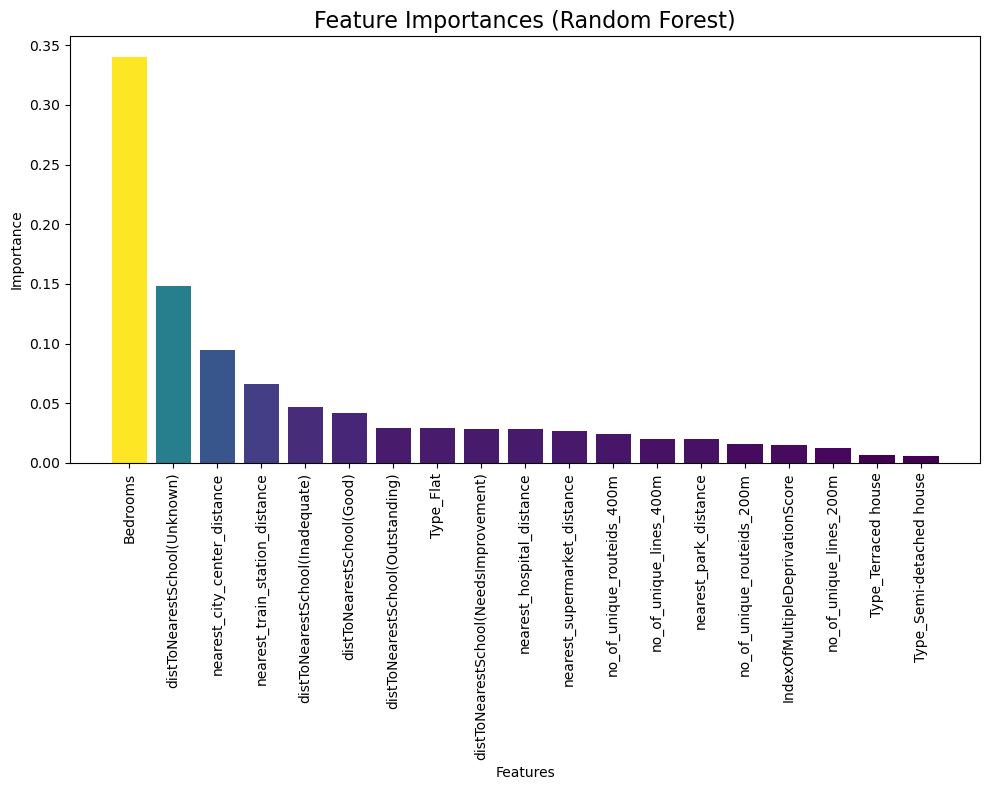


Feature importances:
Feature: Bedrooms, Importance: 0.3404
Feature: distToNearestSchool(Unknown), Importance: 0.1481
Feature: nearest_city_center_distance, Importance: 0.0946
Feature: nearest_train_station_distance, Importance: 0.0659
Feature: distToNearestSchool(Inadequate), Importance: 0.0472
Feature: distToNearestSchool(Good), Importance: 0.0419
Feature: distToNearestSchool(Outstanding), Importance: 0.0294
Feature: Type_Flat, Importance: 0.0290
Feature: distToNearestSchool(NeedsImprovement), Importance: 0.0287
Feature: nearest_hospital_distance, Importance: 0.0280
Feature: nearest_supermarket_distance, Importance: 0.0267
Feature: no_of_unique_routeids_400m, Importance: 0.0241
Feature: no_of_unique_lines_400m, Importance: 0.0204
Feature: nearest_park_distance, Importance: 0.0199
Feature: no_of_unique_routeids_200m, Importance: 0.0155
Feature: IndexOfMultipleDeprivationScore, Importance: 0.0153
Feature: no_of_unique_lines_200m, Importance: 0.0128
Feature: Type_Terraced house, Importa

In [52]:
# Extract feature names from the original DataFrame before converting to NumPy arrays
feature_names = df_encoded.columns

# Extract and sort feature importances
importances_rf = model_rf.feature_importances_
indices_rf = np.argsort(importances_rf)[::-1]

# Check and remove 'const' or similar feature if present
if 'const' in feature_names:
    const_index = feature_names.get_loc('const')
    indices_rf = indices_rf[indices_rf != const_index]
    importances_rf = np.delete(importances_rf, const_index)
    feature_names = feature_names.drop('const')

# Sort features and importances according to sorted indices
sorted_features = [feature_names[i] for i in indices_rf]
sorted_importances = importances_rf[indices_rf]

# Plotting feature importances with Viridis color map
norm = plt.Normalize(vmin=min(sorted_importances), vmax=max(sorted_importances))
colors = cm.viridis(norm(sorted_importances))

plt.figure(figsize=(10, 8))
plt.title("Feature Importances (Random Forest)", fontsize=16)
bars = plt.bar(range(len(indices_rf)), sorted_importances, color=colors, align="center")
plt.xticks(range(len(indices_rf)), sorted_features, rotation=90)
plt.xlabel('Features')
plt.ylabel('Importance')
plt.tight_layout()
plt.show()

# Print feature names and their importance scores
print("\nFeature importances:")
for feature, importance in zip(sorted_features, sorted_importances):
    print(f"Feature: {feature}, Importance: {importance:.4f}")

<h3> XGBOOST WITH BAYESIAN OPTIMIZATION  <h3>

In [13]:
# Define the hyperparameter space for XGBoost
param_space_xgb = [
    Integer(3, 15, name="max_depth"),
    Real(0.01, 0.5, name="learning_rate"),
    Integer(100, 500, name="n_estimators"),
    Real(0.5, 1.0, name="subsample"),
    Real(0.1, 0.9, name="colsample_bytree"),
    Real(0.01, 0.5, name="reg_alpha"),
    Real(0.01, 0.5, name="reg_lambda")
]

@use_named_args(param_space_xgb)
def objective_xgb(**params):
    model = xgb.XGBRegressor(
        objective='reg:squarederror',
        random_state=42,
        **params
    )
    return -np.mean(cross_val_score(model, X_train, y_train, cv=5, n_jobs=-1, scoring="neg_mean_squared_error"))

# Run Bayesian optimization
res_gp_xgb = gp_minimize(objective_xgb, param_space_xgb, n_calls=50, random_state=42, verbose=True, n_jobs=10)
print("Best parameters for XGBoost: ", res_gp_xgb.x)
best_params_xgb = {name: value for name, value in zip([d.name for d in param_space_xgb], res_gp_xgb.x)}

# Train the model with the best parameters
model_xgb = xgb.XGBRegressor(objective='reg:squarederror', random_state=42, **best_params_xgb)
model_xgb.fit(X_train, y_train)

# Predict and evaluate
y_pred_xgb = model_xgb.predict(X_test)
y_test_orig_scale = np.expm1(y_test)  # Convert test values back to original scale if log-transformed
y_pred_orig_scale_xgb = np.expm1(y_pred_xgb)  # Convert predictions back to original scale

mse_xgb = mean_squared_error(y_test_orig_scale, y_pred_orig_scale_xgb)
r2_xgb = r2_score(y_test_orig_scale, y_pred_orig_scale_xgb)
print(f"Mean Squared Error (XGBoost): {mse_xgb}")
print(f"R2 score (XGBoost): {r2_xgb}")


Iteration No: 1 started. Evaluating function at random point.
Iteration No: 1 ended. Evaluation done at random point.
Time taken: 10.9490
Function value obtained: 0.0208
Current minimum: 0.0208
Iteration No: 2 started. Evaluating function at random point.
Iteration No: 2 ended. Evaluation done at random point.
Time taken: 2.7106
Function value obtained: 0.0190
Current minimum: 0.0190
Iteration No: 3 started. Evaluating function at random point.
Iteration No: 3 ended. Evaluation done at random point.
Time taken: 2.7423
Function value obtained: 0.0320
Current minimum: 0.0190
Iteration No: 4 started. Evaluating function at random point.
Iteration No: 4 ended. Evaluation done at random point.
Time taken: 0.4572
Function value obtained: 0.0249
Current minimum: 0.0190
Iteration No: 5 started. Evaluating function at random point.
Iteration No: 5 ended. Evaluation done at random point.
Time taken: 1.5168
Function value obtained: 0.0297
Current minimum: 0.0190
Iteration No: 6 started. Evaluatin



The XGBoost model was optimized using Bayesian optimization. The goal was to identify the best set of hyperparameters to minimize the Mean Squared Error (MSE) and maximize the R² score.ers:
- **Max Depth**: 15
- **Learning Rate**: 0.0363
- **Number of Estimators**: 265
- **Subsample**: 0.5892
- **Colsample_bytree**: 0.6429
- **Gamma**: 0.0534
- **Alpha (L1 Regularization term)* Performance:
- **Mean Squared Error (MSE)**: 18970.1719
- **R² Score**: 0.8888

The optimized XGBoost model with these hyperparameters achieved a Mean Squared Error of 18970.1719, indicating the average squared difference between the predicted and actual rental prices. The R² score of 0.8888 suggests that approximately 88.88% of the variance in the rental prices can be explained by the model. This high R² score indicates a strong predictive performance.


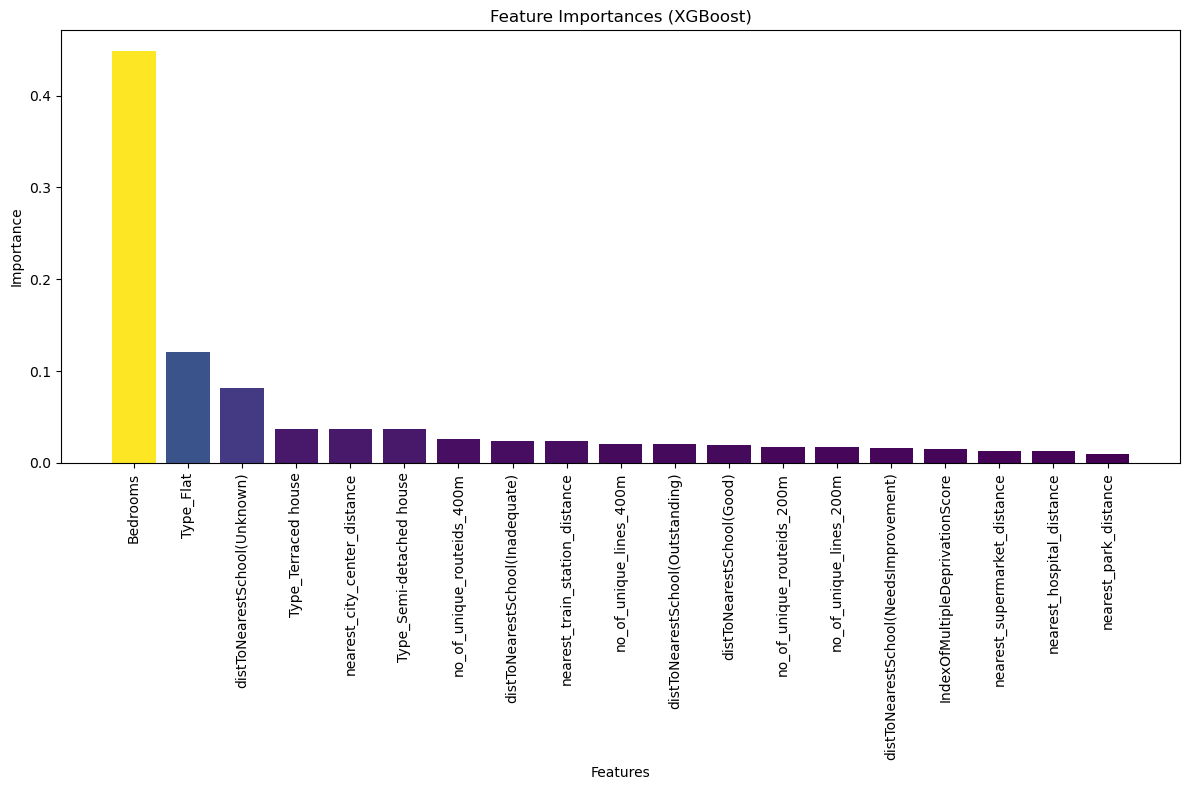


Feature importances:
Feature: Bedrooms, Importance: 0.4486
Feature: Type_Flat, Importance: 0.1211
Feature: distToNearestSchool(Unknown), Importance: 0.0817
Feature: Type_Terraced house, Importance: 0.0371
Feature: nearest_city_center_distance, Importance: 0.0369
Feature: Type_Semi-detached house, Importance: 0.0368
Feature: no_of_unique_routeids_400m, Importance: 0.0261
Feature: distToNearestSchool(Inadequate), Importance: 0.0242
Feature: nearest_train_station_distance, Importance: 0.0237
Feature: no_of_unique_lines_400m, Importance: 0.0209
Feature: distToNearestSchool(Outstanding), Importance: 0.0209
Feature: distToNearestSchool(Good), Importance: 0.0200
Feature: no_of_unique_routeids_200m, Importance: 0.0175
Feature: no_of_unique_lines_200m, Importance: 0.0168
Feature: distToNearestSchool(NeedsImprovement), Importance: 0.0165
Feature: IndexOfMultipleDeprivationScore, Importance: 0.0155
Feature: nearest_supermarket_distance, Importance: 0.0133
Feature: nearest_hospital_distance, Impo

In [54]:
# After applying one-hot encoding, extract the new feature names
feature_names = df_encoded.columns.drop('log_price')

# Extract and sort feature importances from the XGBoost model
importances_xgb = model_xgb.feature_importances_
indices_xgb = np.argsort(importances_xgb)[::-1]  # Sort by descending importance

# Check if 'const' or similar feature exists and remove it if present
if 'const' in feature_names:
    const_index = feature_names.get_loc('const')
    indices_xgb = indices_xgb[indices_xgb != const_index]
    importances_xgb = np.delete(importances_xgb, const_index)
    feature_names = feature_names.drop('const')

# Sort features and importances according to sorted indices
sorted_features = [feature_names[i] for i in indices_xgb]
sorted_importances = importances_xgb[indices_xgb]

# Plotting feature importances with Viridis color map
norm = plt.Normalize(vmin=min(sorted_importances), vmax=max(sorted_importances))
colors = cm.viridis(norm(sorted_importances))

plt.figure(figsize=(12, 8))
plt.title("Feature Importances (XGBoost)")
bars = plt.bar(range(len(indices_xgb)), sorted_importances, color=colors, align="center")
plt.xticks(range(len(indices_xgb)), sorted_features, rotation=90)
plt.xlabel('Features')
plt.ylabel('Importance')
plt.tight_layout()
plt.show()

# Print feature names and their importance scores
print("\nFeature importances:")
for feature, importance in zip(sorted_features, sorted_importances):
    print(f"Feature: {feature}, Importance: {importance:.4f}")

The XGBoost model yielded the best performance among the evaluated models. The optimized hyperparameters for the XGBoost model were a maximum depth of 7, a learning rate of 0.118, 439 estimators, a subsample of 1.0, a colsample_bytree of 0.779, a reg_alpha of 0.321, and a reg_lambda of 0.115. These parameters were obtained through Bayesian optimization. The model achieved a Mean Squared Error (MSE) of 16034.35 and an R-squared (R2) score of 0.906 on the test set, indicating a high level of predictive accuracy. The R2 score of 0.906 signifies that approximately 90.6% of the variability in the rental prices can be explained by the model's predictors.

<H4>PARTIAL DEPENDENCE PLOTS<H4>

In [14]:
# Ensure feature_names_after_preprocessing matches X_train.columns
feature_names_after_preprocessing = X.columns.tolist()

# Split features into bus-related and hedonic categories based on the updated feature names
bus_features = [
     'no_of_unique_lines_200m', 'no_of_unique_routeids_200m', 'no_of_unique_lines_400m', 'no_of_unique_routeids_400m', 'nearest_train_station_distance'
]

hedonic_features = [
    'Bedrooms', 'Type_Flat', 'Type_Semi-detached house', 'Type_Terraced house',
    'nearest_hospital_distance', 'nearest_park_distance', 'nearest_supermarket_distance',
    'nearest_city_center_distance',  'distToNearestSchool(Good)', 'distToNearestSchool(Outstanding)', 'distToNearestSchool(NeedsImprovement)',
    'distToNearestSchool(Inadequate)', 'distToNearestSchool(Unknown)',
    'IndexOfMultipleDeprivationScore'
]


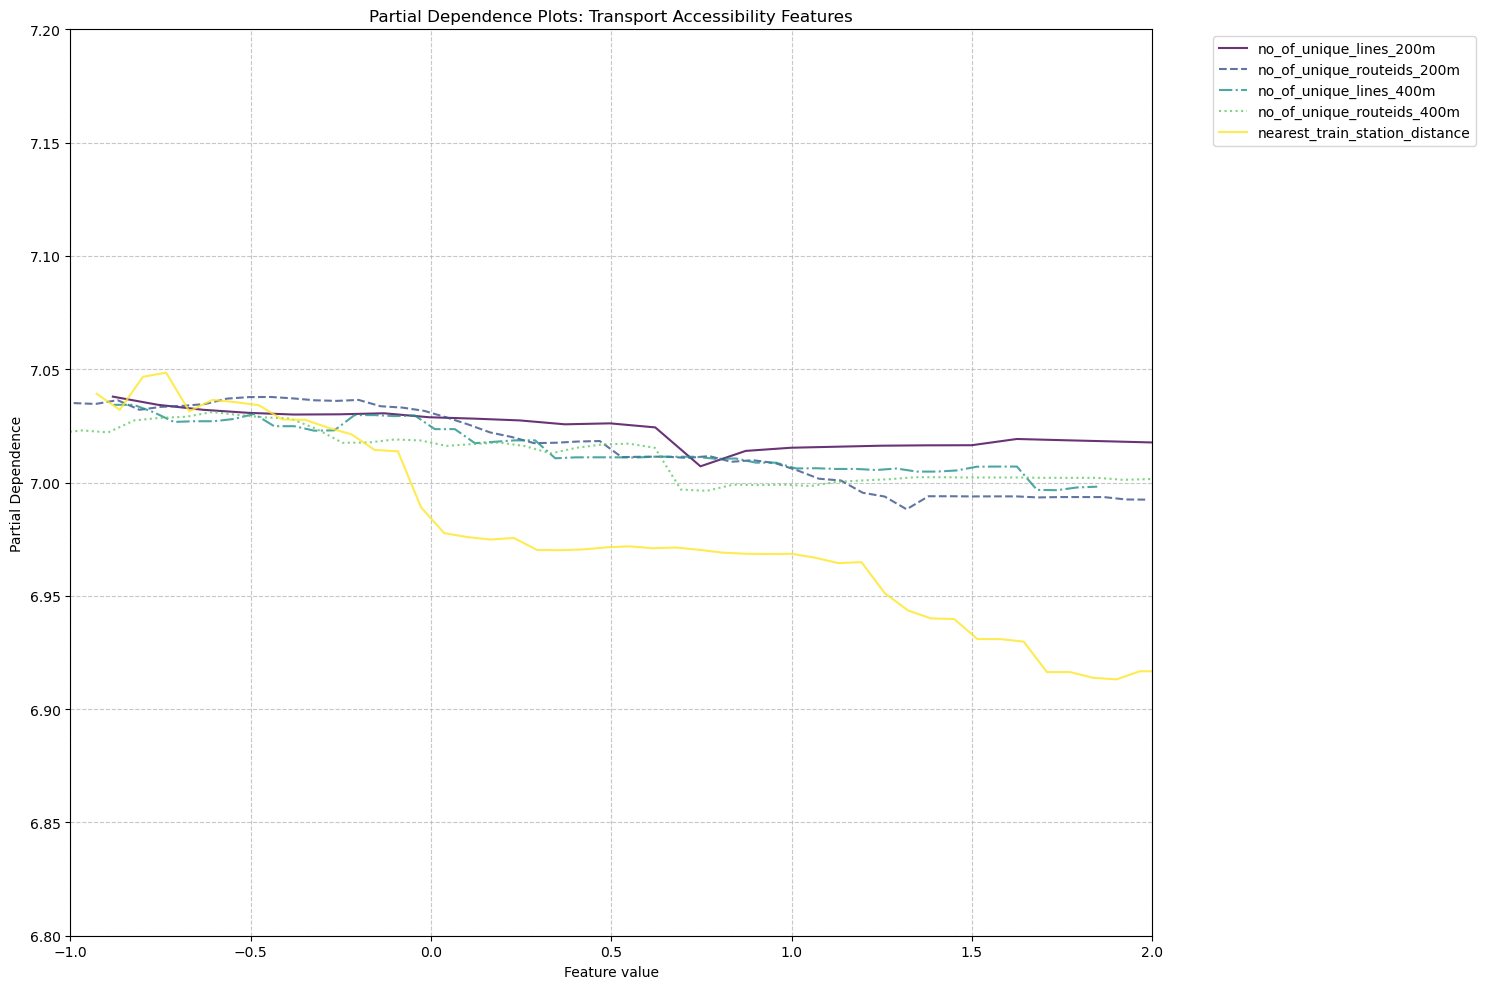

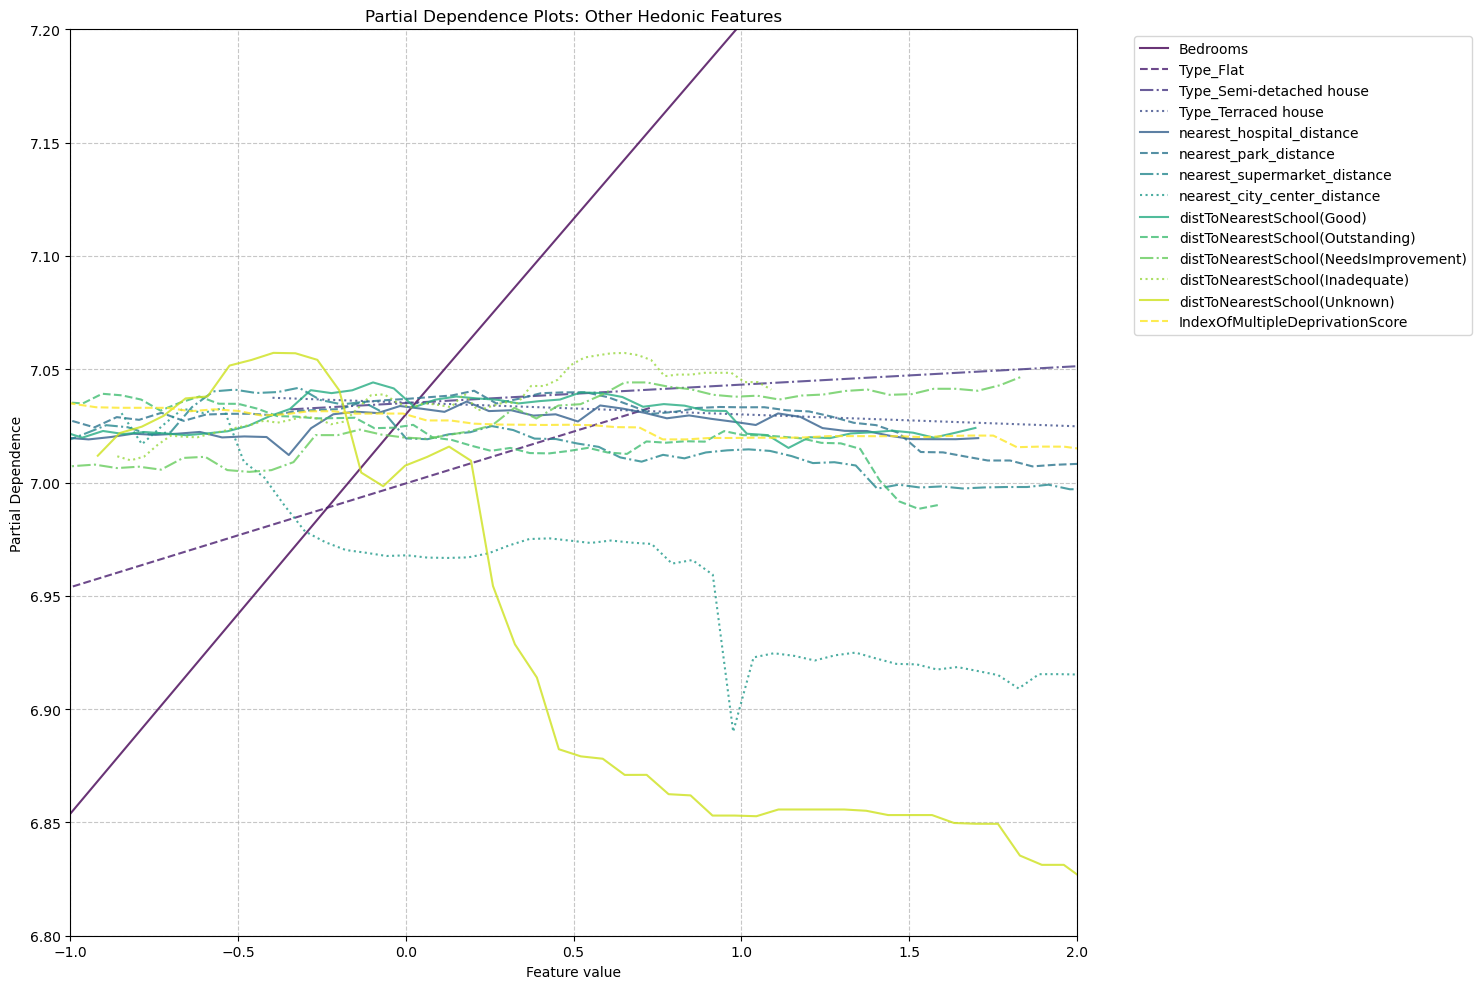

In [21]:
# Function to plot partial dependence for a set of features with different line styles and zoom in

def plot_partial_dependence_combined(model, X, features, feature_names, title, x_limits=None, y_limits=None, save_path=None):
    n_features = len(features)
    cmap = plt.cm.get_cmap('viridis', n_features)
    colors = [cmap(i) for i in range(n_features)]
    linestyles = ['-', '--', '-.', ':'] * (n_features // 4 + 1)
    
    plt.figure(figsize=(15, 10))
    
    for i, feature in enumerate(features):
        feature_index = feature_names.index(feature)
        pdp_results = partial_dependence(model, X, [feature_index], grid_resolution=50)
        pdp_values = pdp_results['average'][0]
        values = pdp_results['values'][0]
        
        plt.plot(values, pdp_values, label=feature, color=colors[i], linestyle=linestyles[i], alpha=0.8)
    
    plt.grid(True, linestyle='--', alpha=0.7)
    plt.xlabel('Feature value')
    plt.ylabel('Partial Dependence')
    plt.title(title)
    
    if x_limits:
        plt.xlim(x_limits)
    if y_limits:
        plt.ylim(y_limits)
    
    plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
    plt.tight_layout()
    
    if save_path:
        plt.savefig(save_path, format='png')
    
    plt.show()

# Define x and y limits for zooming in
x_limits = (-1, 2)  # Adjust these values as needed
y_limits = (6.8, 7.2)  # Adjust these values as needed

# Save the plots as PNG files
bus_features_save_path = 'partial_dependence_bus_features.png'
hedonic_features_save_path = 'partial_dependence_hedonic_features.png'

# Plot bus-related features with zoomed-in view and save the plot
plot_partial_dependence_combined(model_xgb, X_train, bus_features, feature_names_after_preprocessing, 
                                 'Partial Dependence Plots: Transport Accessibility Features', 
                                 x_limits, y_limits, save_path=bus_features_save_path)

# Plot hedonic features with zoomed-in view and save the plot
plot_partial_dependence_combined(model_xgb, X_train, hedonic_features, feature_names_after_preprocessing, 
                                 'Partial Dependence Plots: Other Hedonic Features', 
                                 x_limits, y_limits, save_path=hedonic_features_save_path)


The partial dependence plots show that number of bedrooms has consistent upwards trend so it has the most impact on the rental prices. Different property types (Type_Flat, Type_Semi-detached house, Type_Terraced house) show varied impacts on property prices. For instance, flats (Type_Flat) show a lower partial dependence compared to semi-detached houses. The IndexOfMultipleDeprivationScore displays a notable downward trend, suggesting that properties in areas with higher deprivation scores are associated with lower prices. This reflects the negative impact of socio-economic deprivation on property values. Nearest Hospital Distance: The plot shows a clear negative impact, with property prices decreasing as the distance to the nearest hospital increases. Similarly, there is a negative impact observed, indicating that properties further away from parks tend to have lower prices. The trend suggests a negative impact, with prices decreasing as the distance to the nearest supermarket increases. The plot shows a significant negative impact, highlighting that properties closer to the city center are generally more valuable. Various categories of school distances (Good, Outstanding, NeedsImprovement, Inadequate, Unknown) all show a negative impact on property prices as the distance to the nearest school increases.

<H3>VISUALIZATIONS BY MSOA<H3>

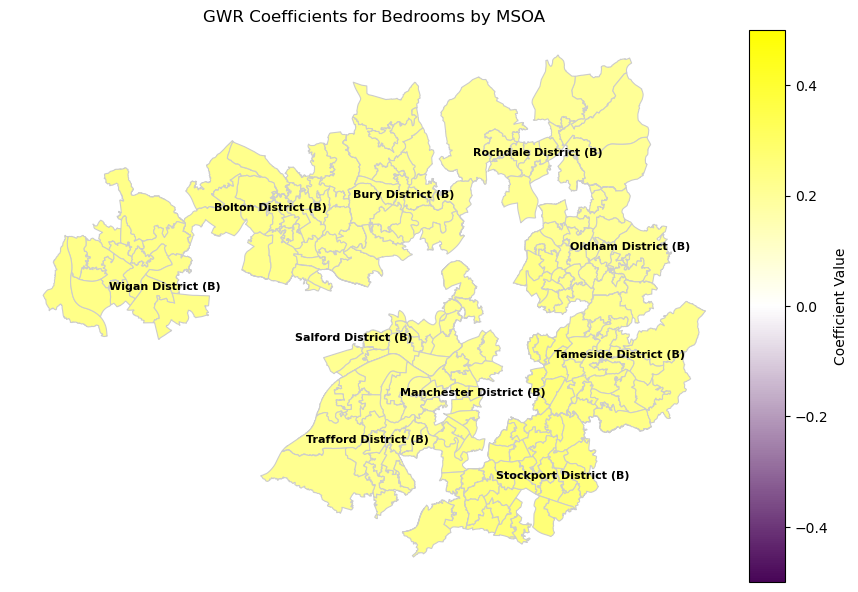

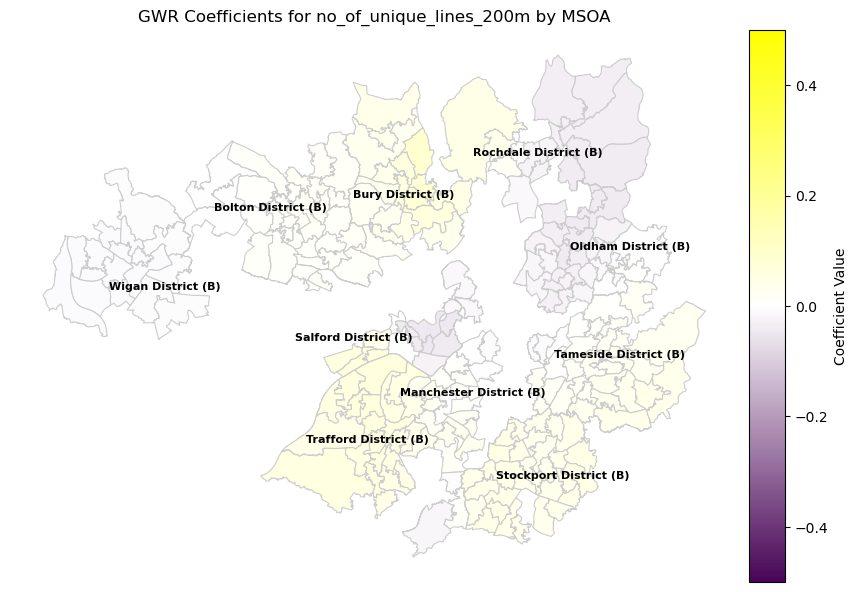

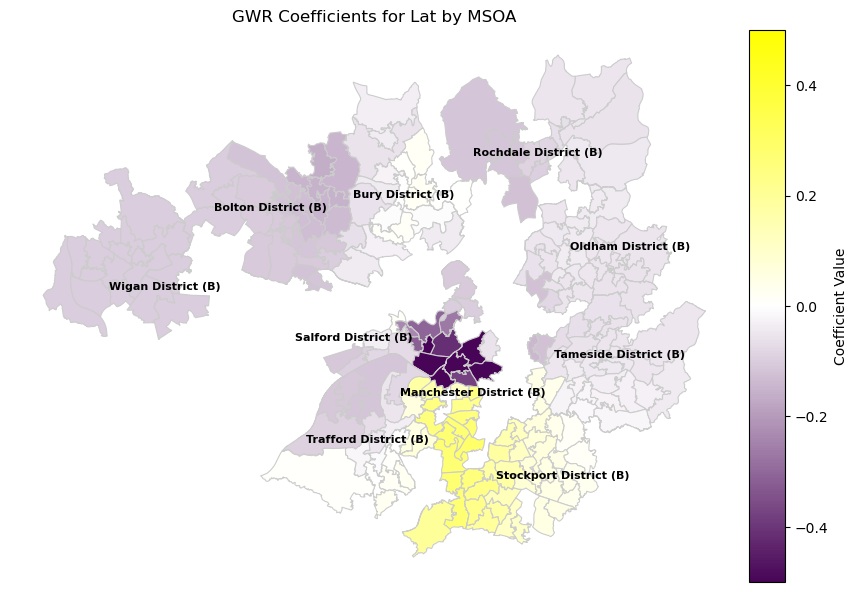

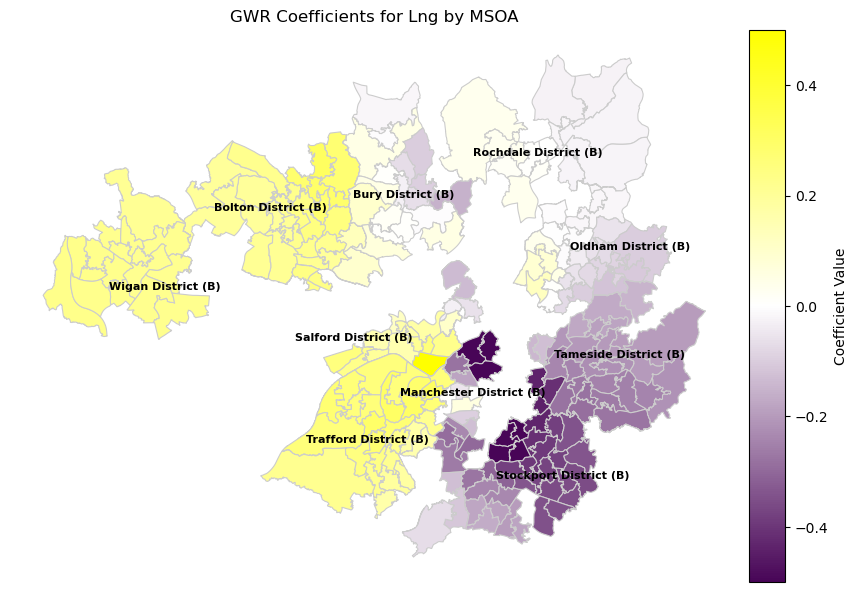

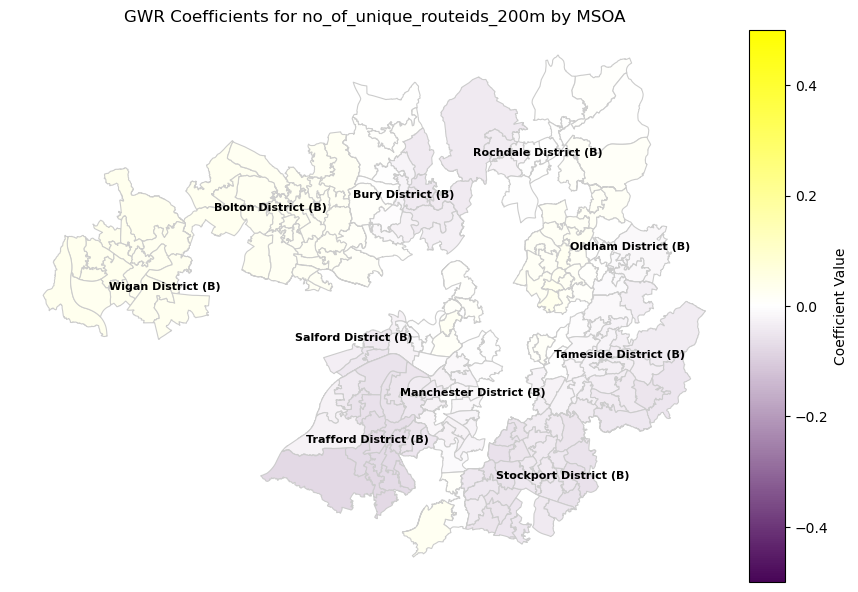

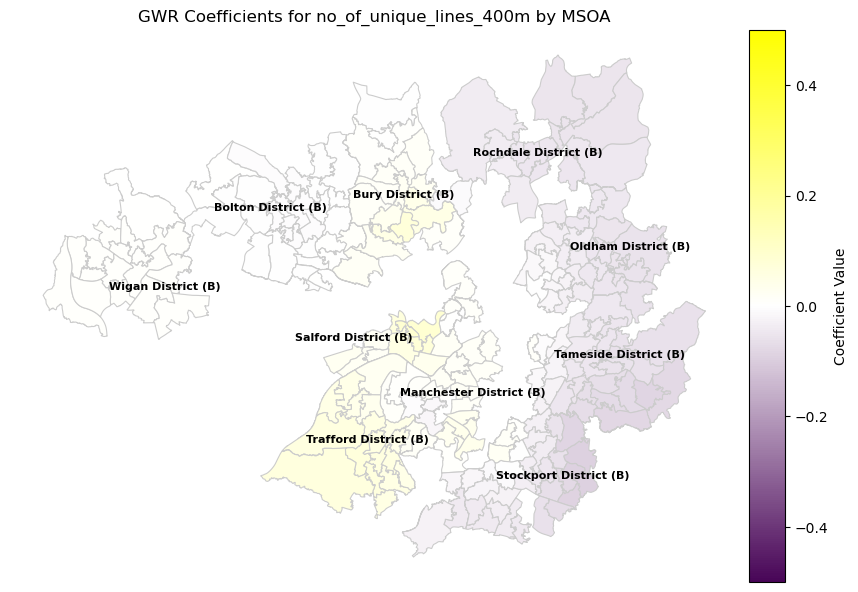

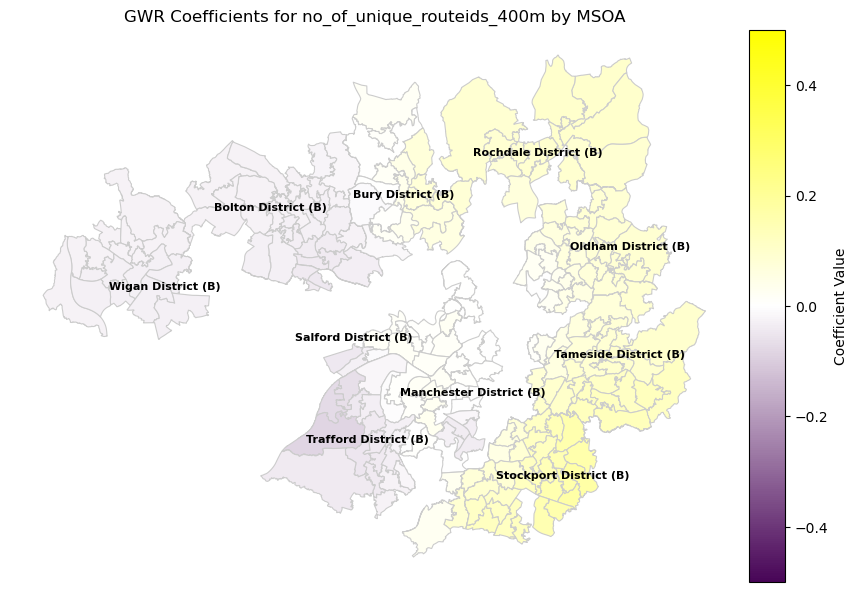

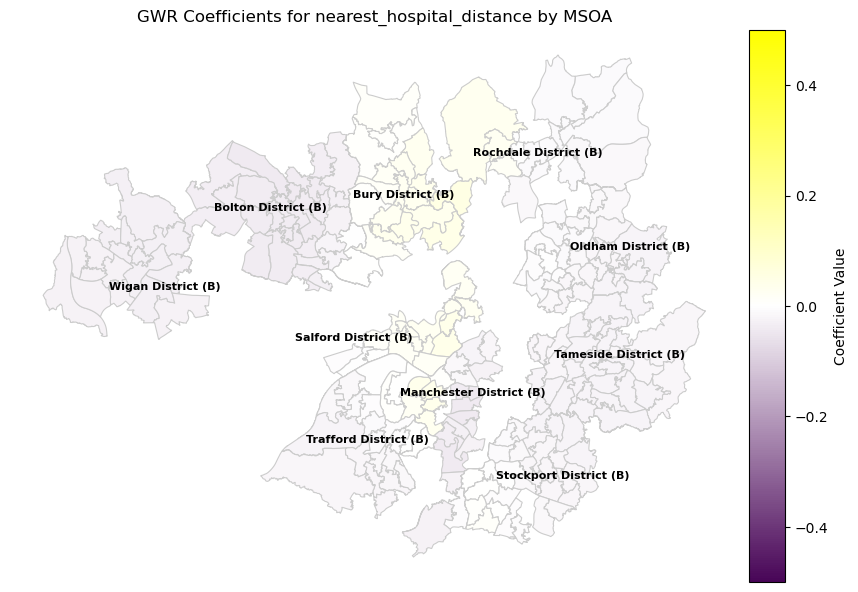

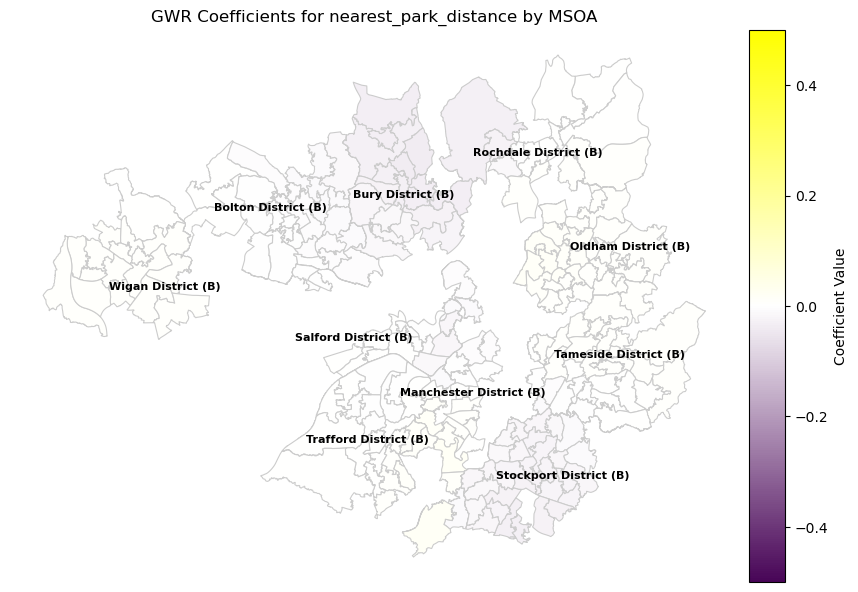

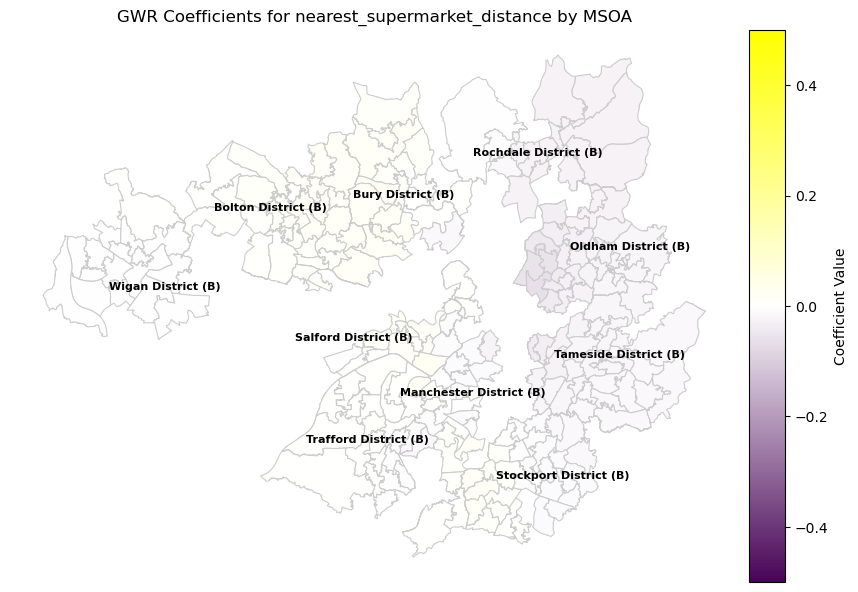

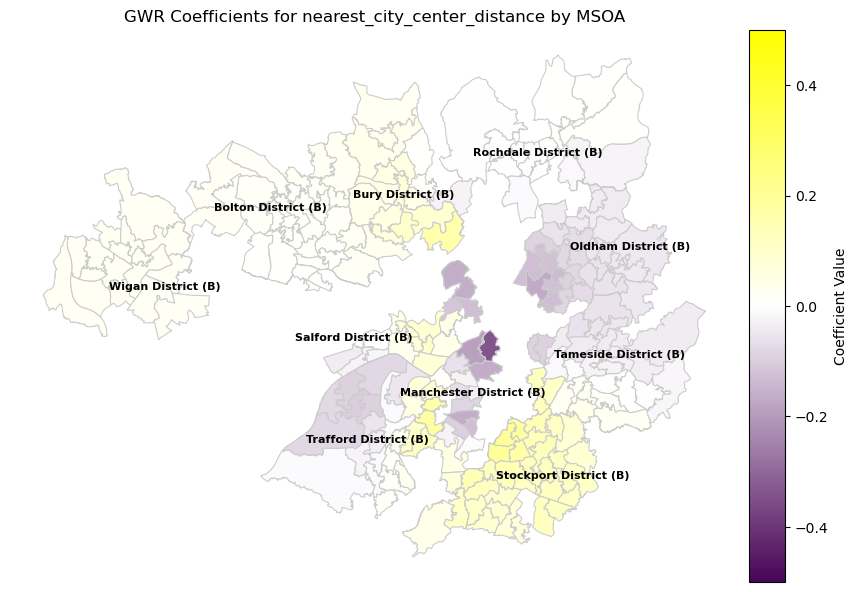

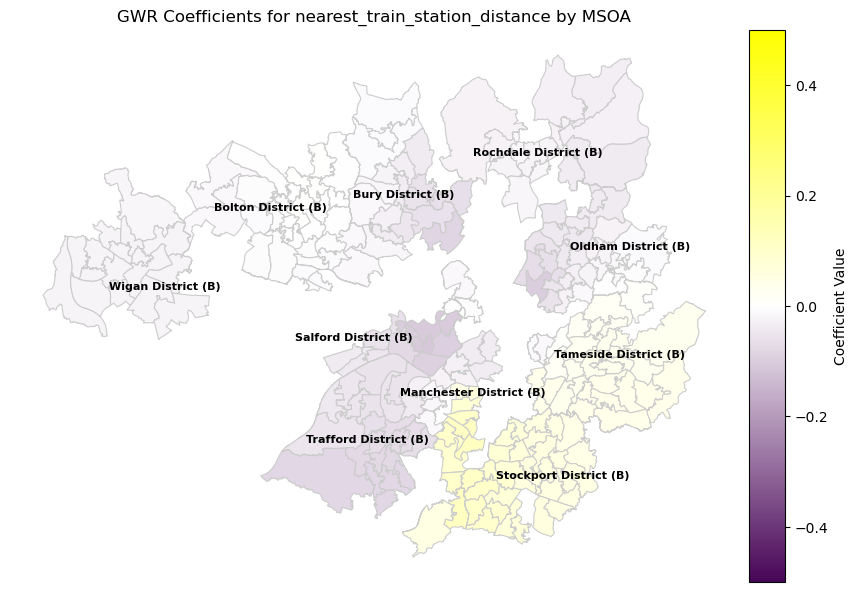

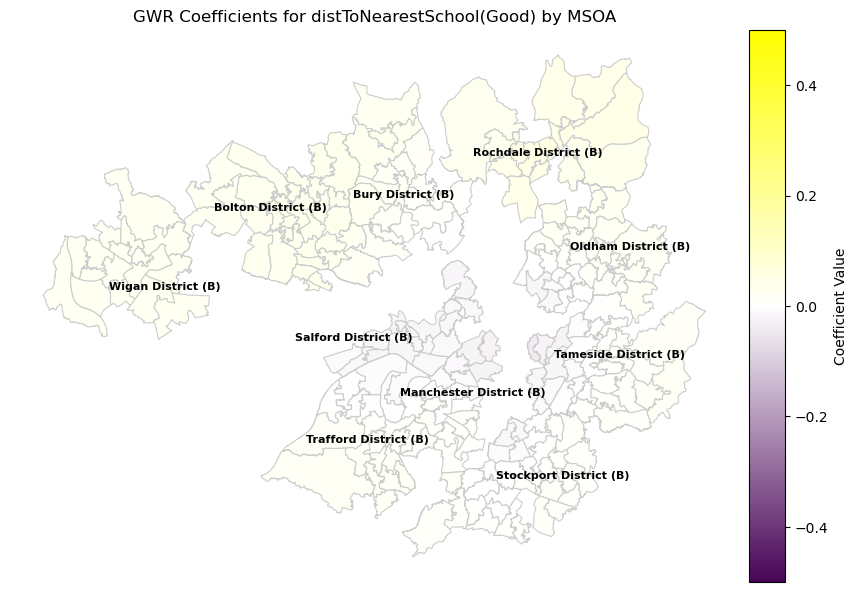

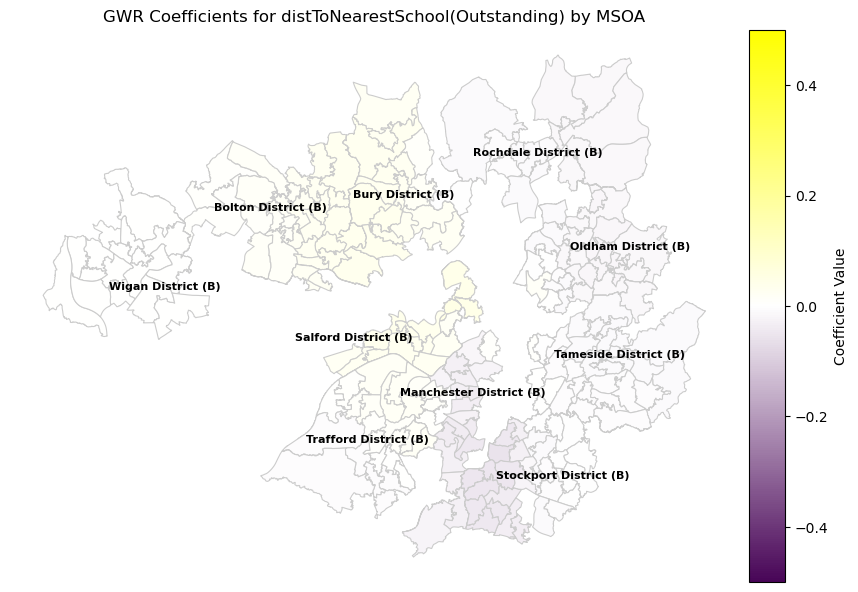

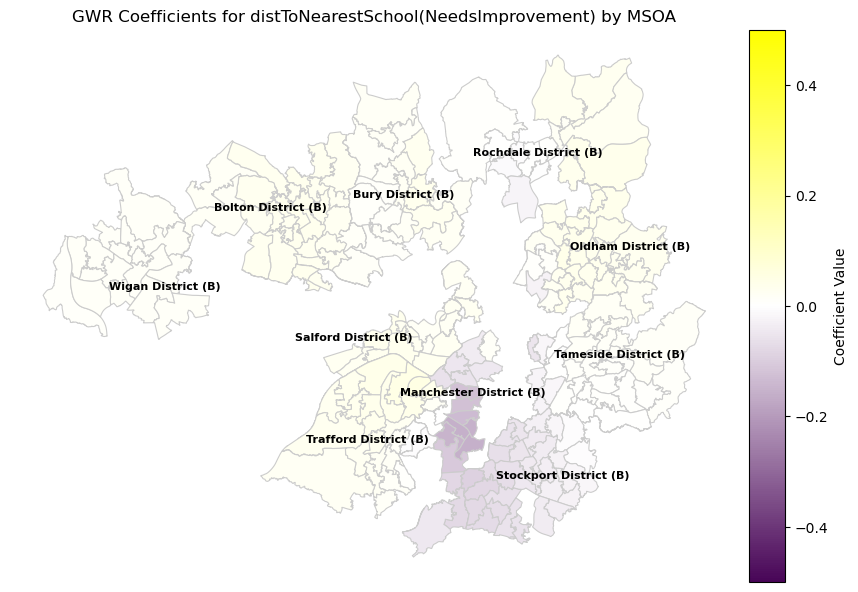

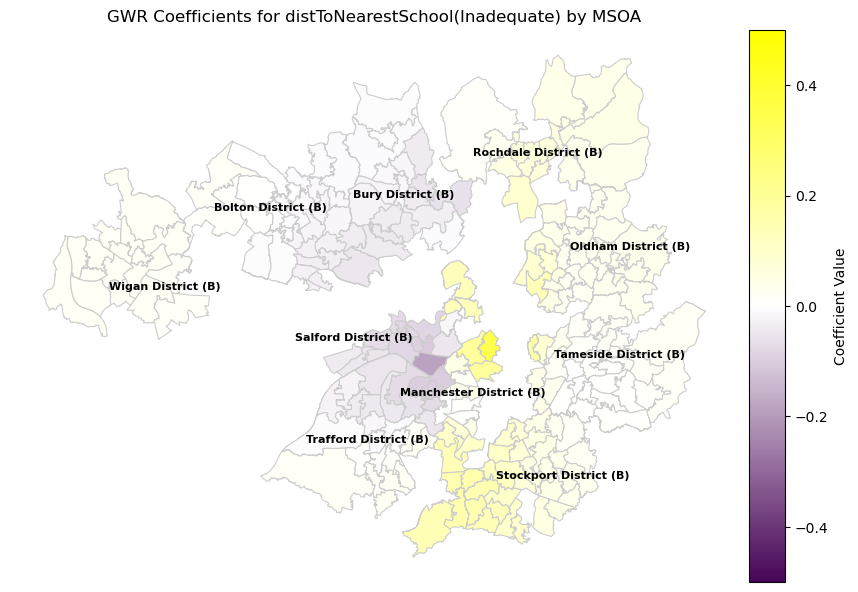

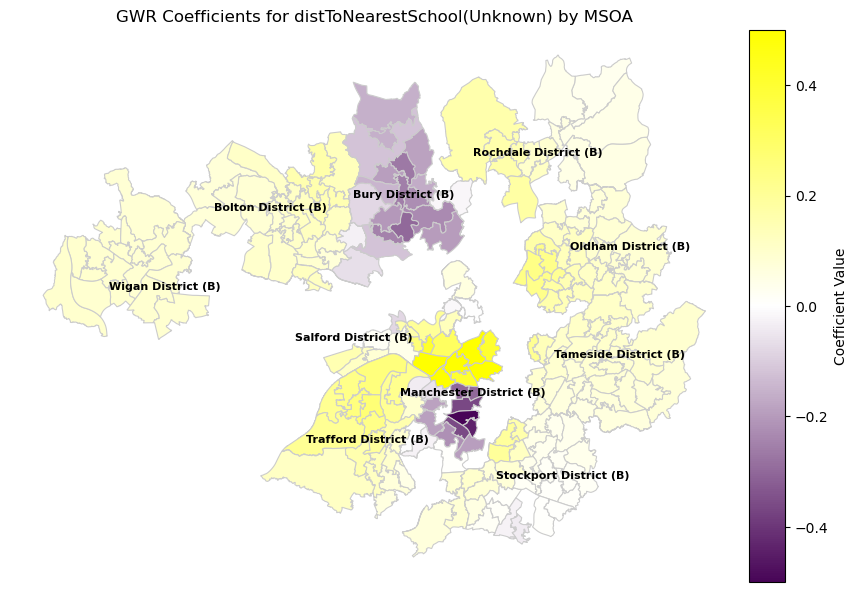

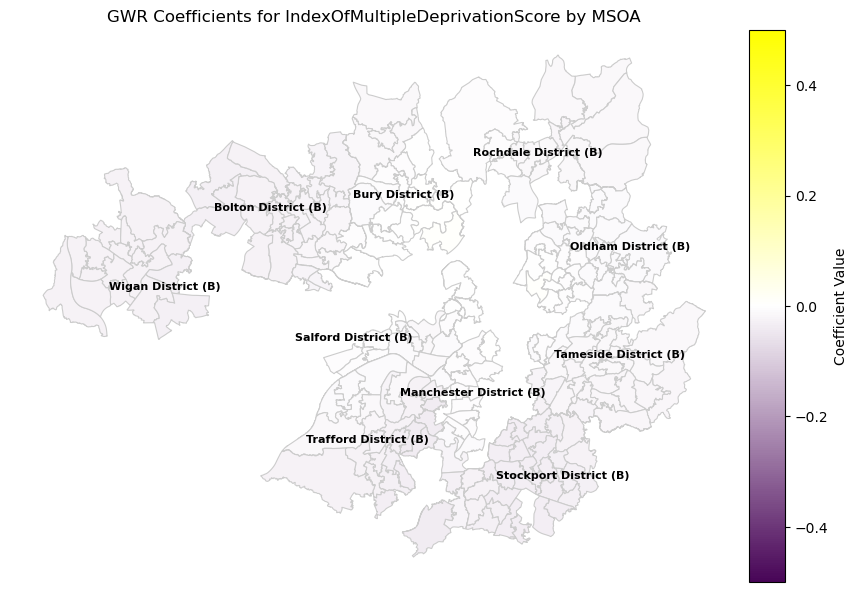

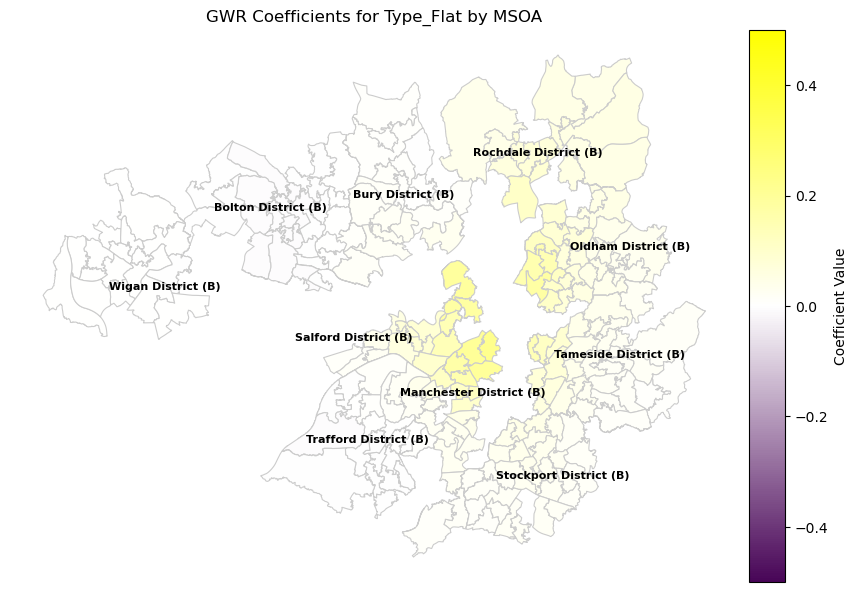

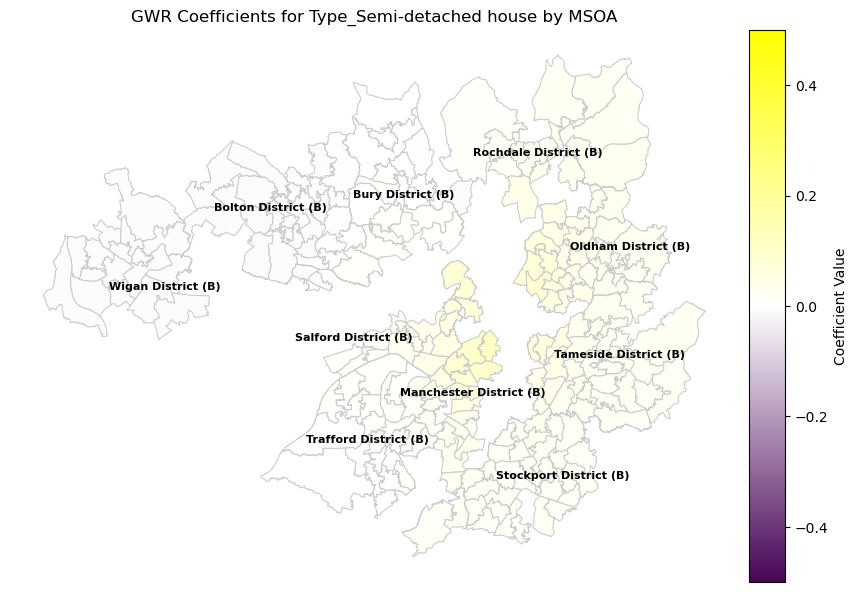

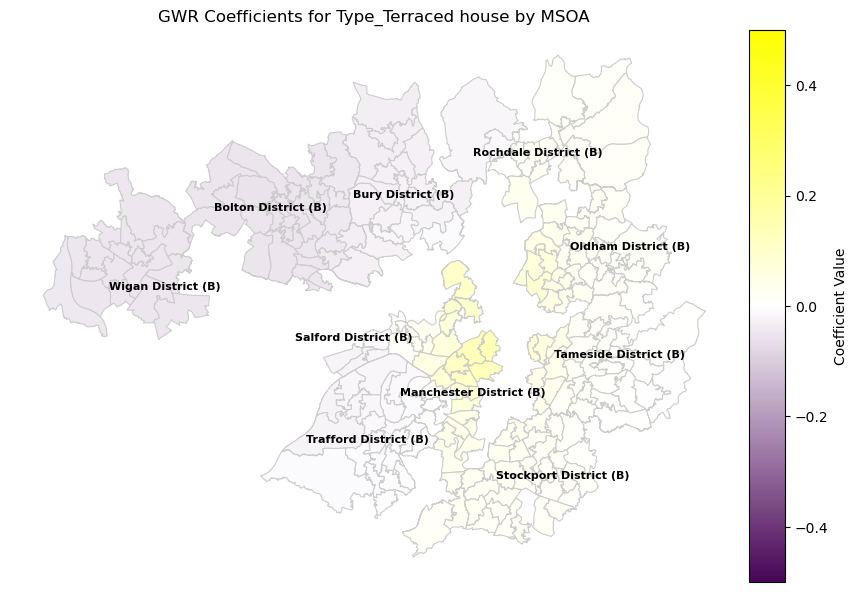

In [138]:
# Re-project the GeoDataFrames to a projected CRS (EPSG:3857) for accurate spatial analysis
gmcr_boroughs = gmcr_boroughs.to_crs(epsg=3857)
gmcr_msoas = gmcr_msoas.to_crs(epsg=3857)

# Extract the coefficients from the best GWR model results, excluding the intercept
gwr_coefficients = best_results_semi_log.params[:, 1:]

# Add the MSOA column to df_filtered for aggregation
df_filtered['MSOA'] = df['MSOA']

# Create a DataFrame for coefficients by MSOA
coefficients_by_msoa = df_filtered[['MSOA']].copy()
coefficients_by_msoa = coefficients_by_msoa.join(pd.DataFrame(gwr_coefficients, columns=X_semi_log.columns))

# Calculate the mean coefficients for each MSOA
mean_coefficients_by_msoa = coefficients_by_msoa.groupby('MSOA').mean().reset_index()

# Merge the mean coefficients with the MSOA GeoDataFrame
msoa_gdf = gmcr_msoas.merge(mean_coefficients_by_msoa, left_on='MSOA01CD', right_on='MSOA', how='left')

# Define a smaller color scale for better visualization
scale_factor = 0.5  # Adjust the scale factor as needed
norm = mcolors.TwoSlopeNorm(vmin=-scale_factor, vcenter=0, vmax=scale_factor)

# Custom colormap with dark purple for negative values and vibrant yellow for positive values
cmap = mcolors.LinearSegmentedColormap.from_list("custom_cmap", ["#480557", "white", "#FFFF00"])

# Plot the GWR coefficients for each feature
for i, feature in enumerate(X_semi_log.columns):
    fig, ax = plt.subplots(figsize=(10, 10))

    # Plot the MSOA GeoDataFrame with the adjusted color normalization
    msoa_gdf.plot(column=feature, cmap=cmap, linewidth=0.8, edgecolor='0.8', ax=ax, legend=False, norm=norm)

    # Annotate borough names on the map
    gmcr_boroughs_centroids = gmcr_boroughs.geometry.centroid
    for x, y, label in zip(gmcr_boroughs_centroids.x, gmcr_boroughs_centroids.y, gmcr_boroughs['NAME']):
        ax.text(x, y, label, fontsize=8, ha='center', color='black', weight='bold')

    ax.set_title(f'GWR Coefficients for {feature} by MSOA')
    ax.axis('off')  # Remove the coordinate axes

    # Add a color bar to the right of the plot
    divider = make_axes_locatable(ax)
    cax = divider.append_axes("right", size="5%", pad=0.1)
    sm = plt.cm.ScalarMappable(cmap=cmap, norm=norm)
    sm._A = []
    cbar = fig.colorbar(sm, cax=cax, orientation='vertical')
    cbar.set_label('Coefficient Value')

    # Save the plot as a PNG file
    plt.savefig(f'final_gwr_spatial_{i+308}_{feature}.png', format='png', bbox_inches='tight')

    plt.show()


**Analysis of Geographically Varying Coefficients for Rental Prices**
**Property Type**
The geographically varying coefficients for property type suggest that rental prices for flats, semi-detached houses, and terraced houses are naturally higher in central areas of Greater Manchester. These property types generally show a positive association with rental prices in central parts compared to less central ones. This indicates that properties in central areas have a higher value due to their location.

**Index of Multiple Deprivation (IMD)**
The IMD has a negative to mildly positive correlation with rental prices, which is more evident in the suburbs than in central parts. While there are deprived zones in central Manchester, the impact on rental prices is mixed throughout the region. The IMD mostly shows a negative to mildly positive impact on rental prices, suggesting other factors in city centers affect the complexities of the hedonic model.

**Distance to Nearest Schools**
Unknown-rated Schools: Distance to unknown-rated schools shows a positive impact on rental prices in both central and suburban parts of Greater Manchester. Inadequate prominence is observed to the south of Stockport and towards Manchester, with mild impacts in Wigan, Rochdale, and Tameside.
Schools Needing Improvement: These have an impact in most districts except Stockport and Manchester.
Outstanding Schools: A positive impact on rental prices is seen in Bury, Bolton, Salford, Trafford, and Wigan.
Good Schools: These show a general positive impact throughout, with mild negative impacts towards central Manchester, possibly due to other complexities involved.
Distance to Nearest Train Stations
The distance to the nearest train station generally shows that as the distance increases, rental prices increase, except in Manchester, Stockport, Tameside, and mildly in the south of Oldham. However, in more western regions like Wigan, Bolton, Bury, and the southern parts of Trafford, as the distance to the nearest train station increases, rental prices also increase. This contradictory finding suggests a complex relationship between train station proximity and rental prices.

**Distance to Nearest Parks**
The map shows that in Greater Manchester, areas like Stockport and Bury have negative coefficients, indicating higher rental prices closer to parks. Conversely, districts such as Rochdale, Oldham, Tameside, Manchester, Trafford, Wigan, and Bolton exhibit positive coefficients, where greater distances from parks correlate with higher rental prices. This spatial variation suggests differing local values placed on park proximity.

**Distance to City Centres**
For places close to city centers, the impact on rental prices is less pronounced, as they are already close to amenities. However, in less central areas, as the distance to the city center increases, rental prices increase, indicating a higher value placed on proximity to city centers in these regions.

**Distance to Nearest Supermarkets**
The distance to the nearest supermarkets shows that in MSOAs in Rochdale, Tameside, Stockport, east of Manchester central, and generally towards the east, as the distance to the supermarket increases, rental prices increase. Contradictory effects are seen in some parts of Bolton, Salford, and west of Manchester, possibly due to the abundance of supermarkets and grocery stores in those areas.

**Distance to Nearest Hospitals**
There is an overall negative correlation between distance to healthcare facilities and rental prices. As the distance to healthcare facilities increases, rental prices generally increase, except in east and north Manchester, east of Salford, and west of Rochdale, where the effect is less pronounced.

**Number of Unique Roads**
The number of unique roads has a positive impact on rental prices in the east belt, including Rochdale, Oldham, Tameside, Stockport, and some parts of Manchester. This suggests that better road connectivity increases property values in these regions.

**Number of Unique Bus Lines**
The number of unique bus lines shows little to no impact on rental prices in the east but has a more pronounced positive impact in the west and less central areas. This indicates that additional bus lines are more valuable in less connected areas.

**Number of Unique Routes within 200m**
The number of unique routes within 200 meters positively affects rental prices in Wigan, Bolton, and Oldham. The impact of the number of unique lines within 200 meters is mixed but statistically significant for the 400-meter ones. The 200-meter impact is likely less significant due to the concentration in more central regions.



<h3> CONCLUSION <h3>

This study supports the hypothesis that public transportation accessibility, particularly bus transport, is significantly associated with rental prices across Greater Manchester. The spatial variability highlighted by models like GWR and XGBoost indicates that while central areas benefit from established connectivity, there is a considerable opportunity to enhance rental values in less central regions through improved transportation infrastructure. These findings provide a comprehensive understanding of the factors influencing rental prices and can guide urban planning and transportation policies to promote equitable development across Greater Manchester.






